In [1]:
from hye_project.my_package.stat_file import normality, stat_test
# -------
# library
# -------

# Standard library

# Typing

# Data handling
import pandas as pd

# Visualization

# Reporting
from tabulate import tabulate

# Statistical analysis
from scipy.stats import pearsonr

# Clustering

# Post-hoc tests

# Modeling

# Network analysis

print(dir(normality))  # test, print_normality
print(dir(stat_test))  # decide, kruskal_dunn, chi2_assoc, p-heatmap

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'print_normality', 'test']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'chi2_assoc', 'decide', 'kruskal_dunn', 'p_heatmap']


In [2]:
csv_path = '/Users/hyeom/Documents/GitHub/advanced_project/Airbnb_project_15/outlier_removed.csv'    # 여기에 absolute path

# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용
    index_col='id',  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)

# 데이터 확인
df.head(2)

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,log_price,room_new_type
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,0,1,1,4.0,4,4,1,1,5.303305,mid
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,0,1,1,4.0,4,4,1,1,4.418841,upper-mid


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20560 entries, 36121 to 1366723228243064949
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_cleansed        20560 non-null  object 
 1   neighbourhood_group_cleansed  20560 non-null  object 
 2   latitude                      20560 non-null  float64
 3   longitude                     20560 non-null  float64
 4   price                         20560 non-null  float64
 5   estimated_occupancy_l365d     20560 non-null  int64  
 6   estimated_revenue_l365d       20560 non-null  float64
 7   availability_60               20560 non-null  int64  
 8   availability_365              20560 non-null  int64  
 9   instant_bookable              20560 non-null  int64  
 10  is_long_term                  20560 non-null  int64  
 11  is_activate                   20560 non-null  int64  
 12  amenities                     20560 non-null  o

In [11]:
X = 'neighbourhood_cleansed'
y = 'log_price'
res = stat_test.kruskal_dunn(df, X, y, verbose=True)


[Kruskal–Wallis: log_price ~ neighbourhood_cleansed]
사용 그룹: 214개 (min_n=2)
제외된 소표본 그룹(6): Chelsea, Staten Island, Gerritsen Beach, Grymes Hill, Holliswood, Oakwood, Willowbrook
Kruskal–Wallis H = 5657.3635, p-value = 0.0000

H0: neighbourhood_cleansed 그룹 간 log_price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 neighbourhood_cleansed 그룹의 log_price 분포가 다르다.

p-value < 0.05 → 귀무가설 기각. Dunn 사후검정(bonferroni) 진행.

[Dunn 다중비교 (bonferroni)]
+---------------------------+------------+-----------------+------------+-----------+-----------+--------------+---------------------+-------------+---------------+--------------+-----------+-------------+----------------------+----------------+-------------+-----------+---------------+----------------+---------------+----------------+----------------+-------------+------------------+-------------+--------------------+---------------+---------------+------------+-------------------+------------+-------------------+---------------+---------------------+-----------+---------

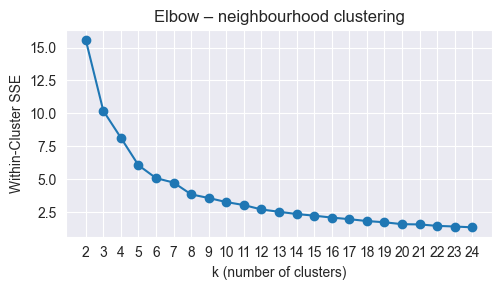

In [230]:
X = 'neighbourhood_cleansed'
y = 'log_price'

# ──────────────────────────────────────────────
# 0) 준비: 동별 특징 벡터 만들기
#    ↳ 위 치(lat·lon) + 중앙가격(log-median)
# ──────────────────────────────────────────────

# ① 동별 위 치 대표값 (평균 또는 중심점)
geo = (
    df.groupby('neighbourhood_cleansed')[['latitude','longitude']]
      .mean()                                # 중심 좌표
)

# ② 동별 가격(로그) 중앙값
price = (
    df.groupby('neighbourhood_cleansed')['log_price']
      .median()
      .to_frame('med_log_price')
)

feat = geo.join(price)                       # (n_dong × 3) 특성행렬
X = feat.values

# ──────────────────────────────────────────────
# 1) Elbow Method 그림으로 k 결정
# ──────────────────────────────────────────────
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ks, sse = range(2, 25), []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    sse.append(km.inertia_)                  # WCSS 합

plt.figure(figsize=(5,3))
plt.plot(ks, sse, marker='o')
plt.xticks(ks)
plt.xlabel('k (number of clusters)')
plt.ylabel('Within-Cluster SSE')
plt.title('Elbow – neighbourhood clustering')
plt.tight_layout(); plt.show()


In [231]:
k_final = 8                 # ← Elbow 그래프 보고 수동 지정
km = KMeans(n_clusters=k_final, random_state=42, n_init='auto').fit(X)

# 동 → 클러스터 매핑 딕셔너리
dong2grp = dict(zip(feat.index, km.labels_))

# 원본 df 에 레이블 부여
df['neigh_cluster'] = df['neighbourhood_cleansed'].map(dong2grp)\
                        .apply(lambda i: f"nbr_grp_{i:02d}")

# 그룹별 샘플 수·가격 요약
summary = (df.groupby('neigh_cluster')['price']
             .agg(['count','median','mean']).sort_values('median', ascending=False))
print(summary.head(10))

# 클러스터 간 가격 차이 유의한지: Kruskal-Wallis
from scipy.stats import kruskal
grp_vals = [g['log_price'].values for _, g in df.groupby('neigh_cluster')]
H, p = kruskal(*grp_vals)
print(f"Kruskal-Wallis  H={H:.1f},  p={p:.3g}")


               count  median        mean
neigh_cluster                           
nbr_grp_07      2203   246.0  269.192011
nbr_grp_01      1618   185.0  208.731768
nbr_grp_04      5935   155.0  181.192418
nbr_grp_05      3830   113.0  127.555614
nbr_grp_00      1377   100.0  116.481481
nbr_grp_03      4077    94.0  112.284278
nbr_grp_06       156    76.5   89.807692
nbr_grp_02      1364    67.0   88.785924
Kruskal-Wallis  H=5390.8,  p=0


In [26]:


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# ───────────────────────────────────────────────────────
# 0) 동별 특징 벡터 준비 (예: 이전에 만든 feat)
#    feat = df.groupby('neighbourhood_cleansed')\
#               [['latitude','longitude','med_log_price']]\
#               .mean()
# ───────────────────────────────────────────────────────
feat = (
    df.groupby('neighbourhood_cleansed')
      [['latitude','longitude']]
      .mean()
      .join(df.groupby('neighbourhood_cleansed')['log_price'].median().rename('med_log_price'))
)

X = feat.values

# ───────────────────────────────────────────────────────
# 1) 스케일링
# ───────────────────────────────────────────────────────
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# ───────────────────────────────────────────────────────
# 2) k별 SSE(Elbow) + 실루엣 계수
# ───────────────────────────────────────────────────────
sse = []
sil_scores = []
k_values = range(6, 9)   # 2부터 12까지 시험해 볼 예시

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(scaled_features)
    sse.append(km.inertia_)
    sil_scores.append(silhouette_score(scaled_features, labels))
    print(f"K={k:2d} →  SSE={km.inertia_:7.2f},  silhouette={sil_scores[-1]:.4f}")


K= 6 →  SSE= 148.51,  silhouette=0.3404
K= 7 →  SSE= 133.78,  silhouette=0.3362
K= 8 →  SSE= 122.28,  silhouette=0.3023


In [29]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor

# 0) 타깃
y = np.log1p(df['price'])

results = []
for k in [6, 7, 8]:
    # ──────────────────────────────────────────
    # A) KMeans 로 neigh_k 레이블 생성
    # ──────────────────────────────────────────
    centers = (
        df.groupby('neighbourhood_cleansed')[['latitude','longitude']]
          .mean()
    )
    km = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(centers.values)
    mapping = dict(zip(centers.index, km.labels_))
    df['neigh_k'] = df['neighbourhood_cleansed'].map(mapping).astype(str)

    # ──────────────────────────────────────────
    # B) Pipeline: OneHot(neigh_k) → HGB regressor
    # ──────────────────────────────────────────
    pipe = Pipeline([
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
        ('hgb', HistGradientBoostingRegressor(
            learning_rate=0.05,
            max_depth=6,
            random_state=42
        ))
    ])

    # ──────────────────────────────────────────
    # C) 5-폴드 CV 로 neg RMSE(log) 계산
    # ──────────────────────────────────────────
    neg_rmses = cross_val_score(
        pipe,
        df[['neigh_k']],
        y,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    rmse = -neg_rmses.mean()
    results.append((k, rmse))

# 4) 결과 정리
res_df = pd.DataFrame(results, columns=['k','CV_RMSE_log']).set_index('k')
print(res_df)


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sk

   CV_RMSE_log
k             
6     0.602577
7     0.601010
8     0.589843


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
X = 'neigh_cluster'
y = 'log_price'
res = stat_test.kruskal_dunn(df, X, y, verbose=True)


[Kruskal–Wallis: log_price ~ neigh_cluster]
사용 그룹: 6개 (min_n=2)
Kruskal–Wallis H = 5278.8741, p-value = 0.0000

H0: neigh_cluster 그룹 간 log_price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 neigh_cluster 그룹의 log_price 분포가 다르다.

p-value < 0.05 → 귀무가설 기각. Dunn 사후검정(bonferroni) 진행.

[Dunn 다중비교 (bonferroni)]
+------------+--------------+--------------+--------------+--------------+--------------+--------------+
|            |   nbr_grp_00 |   nbr_grp_01 |   nbr_grp_02 |   nbr_grp_03 |   nbr_grp_04 |   nbr_grp_05 |
|------------+--------------+--------------+--------------+--------------+--------------+--------------|
| nbr_grp_00 |       1.0000 |       0.0000 |       0.0000 |       0.0002 |       0.0000 |       0.0050 |
| nbr_grp_01 |       0.0000 |       1.0000 |       0.0000 |       0.0000 |       0.0000 |       0.0000 |
| nbr_grp_02 |       0.0000 |       0.0000 |       1.0000 |       0.0000 |       0.0000 |       0.0000 |
| nbr_grp_03 |       0.0002 |       0.0000 |       0.0000 |       1.0000 |      

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import chi2_contingency


df['amen_list'] = df['amenities'].apply(eval)        # 문자열 → 리스트
mlb      = MultiLabelBinarizer()
amen_mat = mlb.fit_transform(df['amen_list'])
amen_df  = pd.DataFrame(amen_mat, columns=mlb.classes_, index=df.index)

df_amen  = pd.concat([df[['room_new_type']], amen_df], axis=1)

price_groups = df_amen['room_new_type'].unique()
amenities    = amen_df.columns

records = []

for amen in amenities:
    # 각 가격군 빈도
    freq = df_amen.groupby('room_new_type')[amen].mean()
    for grp in price_groups:
        p_grp = freq[grp]
        p_oth = freq.drop(grp).mean()
        rr = p_grp / p_oth if p_oth else np.nan

        # 2×k 카이제곱
        cont = pd.crosstab(df_amen['room_new_type'] == grp, df_amen[amen])
        chi2, p, *_ = chi2_contingency(cont, correction=False)

        records.append([amen, grp, p_grp, p_oth, rr, p])

freq_tbl = pd.DataFrame(records, columns=['amenity','group','p_grp','p_others','RR','p'])

COMMON_TH   = 0.70   # 공통 기준
SPECIAL_TH  = 0.40   # 그룹 내 빈도
RR_TH       = 1.5    # 상대풍부도
ALPHA       = 0.05   # 유의수준

# ① 공통 amenity
common_amen = (freq_tbl.groupby('amenity')['p_grp']
                        .min()
                        .loc[lambda s: s >= COMMON_TH]
                        .index.tolist())

# ② 특화 amenity
spec_df = (freq_tbl
           .query("p_grp >= @SPECIAL_TH and RR >= @RR_TH and p < @ALPHA"))

special_by_group = (spec_df.groupby('group')['amenity']
                            .apply(list)
                            .to_dict())

print("공통 amenity (필수):")
print(sorted(common_amen))

for g, lst in special_by_group.items():
    print(f"\n{g} 특화 amenity:")
    print(sorted(lst))

공통 amenity (필수):
['Carbon monoxide alarm', 'Essentials', 'Hangers', 'Smoke alarm', 'Wifi']

high 특화 amenity:
['Air conditioning', 'Building staff', 'Elevator', 'Gym', 'Heating', 'Paid parking off premises', 'Shampoo']

low-mid 특화 amenity:
['Cleaning products', 'Dining table', 'Exterior security cameras on property', 'Free street parking', 'Freezer', 'Laundromat nearby', 'Lock on bedroom door', 'Microwave']

mid 특화 amenity:
['Cooking basics', 'Kitchen', 'Oven']

upper-mid 특화 amenity:
['Bathtub', 'Cleaning products', 'Cooking basics', 'Dishes and silverware', 'Elevator', 'Freezer']


In [39]:
import ast, pandas as pd
from scipy.stats import ttest_ind

df['amen_list'] = df['amenities'].fillna('[]').apply(ast.literal_eval)

amen_dict = {
    'common'    : ['Carbon monoxide alarm','Essentials','Hangers','Smoke alarm','Wifi'],
    'high'      : ['Air conditioning','Building staff','Elevator','Gym','Heating',
                   'Paid parking off premises','Shampoo'],
    'upper_mid' : ['Bathtub','Cleaning products','Cooking basics',
                   'Dishes and silverware','Elevator','Freezer'],
    'mid'       : ['Cooking basics','Kitchen','Oven'],
    'low_mid'   : ['Cleaning products','Dining table','Exterior security cameras on property',
                   'Free street parking','Freezer','Laundromat nearby','Lock on bedroom door',
                   'Microwave']
}

amen_grp = {}
for g, lst in amen_dict.items():
    for a in lst:
        amen_grp[a] = amen_grp.get(a, []) + [g]
amen_grp = {k: " / ".join(v) for k, v in amen_grp.items()}

for amen in amen_grp:
    df[f'has_{amen.replace(" ","_")}'] = df['amen_list'].apply(lambda lst: int(amen in lst))

records = []
for amen in amen_grp:
    col   = f'has_{amen.replace(" ","_")}'
    g1, g0 = df.loc[df[col]==1,'log_price'], df.loc[df[col]==0,'log_price']
    t, p   = ttest_ind(g1, g0, equal_var=False)
    premium = (np.expm1(g1.mean()) / np.expm1(g0.mean()) - 1) * 100     # %
    records.append([amen, amen_grp[amen], len(g1), len(g0), premium, p])

out = (pd.DataFrame(records,
                    columns=['amenity','group','n_have','n_no','premium_%','p'])
         .sort_values('premium_%', ascending=False))

# 보기 좋게 출력
print(tabulate(out[['amenity','group','premium_%','p']],
               headers='keys', tablefmt='github', floatfmt=".2f"))

|    | amenity                               | group               |   premium_% |    p |
|----|---------------------------------------|---------------------|-------------|------|
|  8 | Gym                                   | high                |      103.29 | 0.00 |
|  6 | Building staff                        | high                |       78.88 | 0.00 |
|  7 | Elevator                              | high / upper_mid    |       54.49 | 0.00 |
|  1 | Essentials                            | common              |       43.86 | 0.00 |
| 11 | Shampoo                               | high                |       40.04 | 0.00 |
| 10 | Paid parking off premises             | high                |       33.40 | 0.00 |
|  2 | Hangers                               | common              |       28.64 | 0.00 |
| 12 | Bathtub                               | upper_mid           |       19.69 | 0.00 |
|  5 | Air conditioning                      | high                |       18.08 | 0.00 |
|  3 | Smo

In [40]:
import statsmodels.formula.api as smf

base_vars = ['C(room_new_type)']  # 예시
amen_vars = [f"has_{amen.replace(' ','_')}" for amen in set(amen_grp)]

formula = "log_price ~ " + " + ".join(base_vars + amen_vars)
model   = smf.ols(formula, data=df).fit(cov_type='HC3')

# amenity 계수, p값만 뽑기
amen_coefs = (model.params[amen_vars]
              .to_frame('β')
              .join(model.pvalues[amen_vars].to_frame('p')))
amen_coefs['premium_%'] = (np.exp(amen_coefs['β']) - 1)*100
print(amen_coefs.sort_values('premium_%', ascending=False).head(29))

                                                  β             p  premium_%
has_Gym                                    0.230010  4.657627e-46  25.861283
has_Building_staff                         0.213482  1.340800e-41  23.798155
has_Essentials                             0.167849  8.555790e-45  18.275808
has_Shampoo                                0.156213  9.084993e-79  16.907466
has_Cooking_basics                         0.136336  1.317076e-33  14.606681
has_Bathtub                                0.116411  3.229848e-44  12.345729
has_Elevator                               0.102299  1.742389e-23  10.771462
has_Kitchen                                0.098600  2.772196e-15  10.362488
has_Air_conditioning                       0.092056  1.873074e-28   9.642573
has_Smoke_alarm                            0.055664  6.735562e-03   5.724267
has_Paid_parking_off_premises              0.051101  1.654231e-04   5.242877
has_Dining_table                           0.050379  2.457882e-07   5.166988

In [41]:
df['amen_list'] = df['amenities'].fillna('[]').apply(ast.literal_eval)

amen_dict = {
    'common'    : ['Carbon monoxide alarm','Essentials','Hangers','Smoke alarm','Wifi'],
    'high'      : ['Air conditioning','Building staff','Elevator','Gym','Heating',
                   'Paid parking off premises','Shampoo'],
    'upper_mid' : ['Bathtub','Cleaning products','Cooking basics',
                   'Dishes and silverware','Elevator','Freezer'],
    'mid'       : ['Cooking basics','Kitchen','Oven'],
    'low_mid'   : ['Cleaning products','Dining table','Exterior security cameras on property',
                   'Free street parking','Freezer','Laundromat nearby','Lock on bedroom door',
                   'Microwave']
}

for g, lst in amen_dict.items():
    df[f'{g}_cnt'] = df['amen_list'].apply(lambda L: sum(a in L for a in lst))

In [42]:
cont_cols = [c for c in df.columns if c.endswith('_cnt')]

# 1) Pearson r
for c in cont_cols:
    r, p = pearsonr(df[c], df['log_price'])
    print(f"{c}:  r={r:.3f},  p={p:.3g}")

# 2) 다변량 OLS (count → log_price)
formula = "log_price ~ high_cnt + upper_mid_cnt + mid_cnt + low_mid_cnt"
model   = smf.ols(formula, data=df).fit()
print(model.summary().tables[1])

# β → % 변환 예시
beta_high = model.params['high_cnt']
print("High amenity 1개↑  ⇒  가격 +", round((np.exp(beta_high)-1)*100,1), "%")

amenities_cnt:  r=0.214,  p=3.05e-211
common_cnt:  r=0.192,  p=1.64e-169
high_cnt:  r=0.360,  p=0
upper_mid_cnt:  r=0.131,  p=3.01e-79
mid_cnt:  r=0.076,  p=1.19e-27
low_mid_cnt:  r=-0.091,  p=3.89e-39
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.5420      0.011    400.949      0.000       4.520       4.564
high_cnt          0.1249      0.003     42.632      0.000       0.119       0.131
upper_mid_cnt     0.1430      0.004     33.716      0.000       0.135       0.151
mid_cnt          -0.0311      0.005     -5.976      0.000      -0.041      -0.021
low_mid_cnt      -0.0918      0.003    -31.440      0.000      -0.097      -0.086
High amenity 1개↑  ⇒  가격 + 13.3 %


In [43]:
# High amenity ≥1개 여부
X = 'has_any_high_amen'
df[X] = (df['high_cnt'] > 0).astype(int)

import scipy.stats as stats
g1 = df.loc[df[X]==1, 'log_price']
g0 = df.loc[df[X]==0, 'log_price']

t, p = stats.ttest_ind(g1, g0, equal_var=False)
print(f"mean diff = {np.expm1(g1.mean()) - np.expm1(g0.mean()):.1f} $ , p={p:.3g}")

if p < 0.05 :
    print(f'{X}인 숙소는 그렇지 않은 숙소보다 평균 {np.expm1(g1.mean()) - np.expm1(g0.mean()):.1f} $ 정도 더 비싸다.')

print (t)

mean diff = 17.6 $ , p=2.67e-21
has_any_high_amen인 숙소는 그렇지 않은 숙소보다 평균 17.6 $ 정도 더 비싸다.
9.585635349908845


/var/folders/y0/671x56056fg565s3792l4vnr0000gn/T/ipykernel_55797/669953049.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_any_high_amen', y='price', data=df, palette='pastel', showfliers=False)


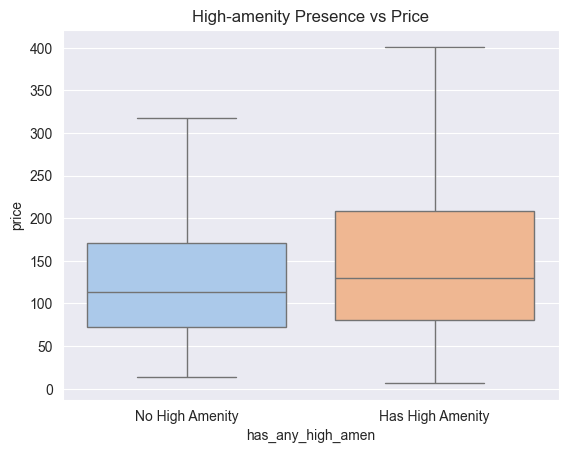

In [45]:
import seaborn as sns, matplotlib.pyplot as plt

sns.boxplot(x='has_any_high_amen', y='price', data=df, palette='pastel', showfliers=False)
plt.xticks([0,1], ['No High Amenity','Has High Amenity'])
plt.title("High-amenity Presence vs Price")
plt.show()

In [47]:
X = 'room_new_type'
y = 'log_price'
res = stat_test.kruskal_dunn(df, X, y, verbose=True)


[Kruskal–Wallis: log_price ~ room_new_type]
사용 그룹: 4개 (min_n=2)
Kruskal–Wallis H = 1891.5204, p-value = 0.0000

H0: room_new_type 그룹 간 log_price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 room_new_type 그룹의 log_price 분포가 다르다.

p-value < 0.05 → 귀무가설 기각. Dunn 사후검정(bonferroni) 진행.

[Dunn 다중비교 (bonferroni)]
+-----------+--------+-----------+--------+-------------+
|           |   high |   low-mid |    mid |   upper-mid |
|-----------+--------+-----------+--------+-------------|
| high      | 1.0000 |    0.0000 | 0.0000 |      0.0000 |
| low-mid   | 0.0000 |    1.0000 | 0.0000 |      0.0000 |
| mid       | 0.0000 |    0.0000 | 1.0000 |      0.0000 |
| upper-mid | 0.0000 |    0.0000 | 0.0000 |      1.0000 |
+-----------+--------+-----------+--------+-------------+

=== 유의한 그룹 쌍 (p < 0.05) ===
+----------+-----------+-----------+
| Group1   | Group2    |   p-value |
|----------+-----------+-----------|
| high     | low-mid   |    0.0000 |
| high     | mid       |    0.0000 |
| high     | upper-mid |    0.00

In [48]:
X = 'room_type'
y = 'log_price'
res = stat_test.kruskal_dunn(df, X, y, verbose=True)


[Kruskal–Wallis: log_price ~ room_type]
사용 그룹: 4개 (min_n=2)
Kruskal–Wallis H = 6650.0690, p-value = 0.0000

H0: room_type 그룹 간 log_price 분포(중앙위치)에 차이가 없다.
H1: 적어도 한 room_type 그룹의 log_price 분포가 다르다.

p-value < 0.05 → 귀무가설 기각. Dunn 사후검정(bonferroni) 진행.

[Dunn 다중비교 (bonferroni)]
+-----------------+-------------------+--------------+----------------+---------------+
|                 |   Entire home/apt |   Hotel room |   Private room |   Shared room |
|-----------------+-------------------+--------------+----------------+---------------|
| Entire home/apt |            1.0000 |       0.0000 |         0.0000 |        0.0000 |
| Hotel room      |            0.0000 |       1.0000 |         0.0000 |        0.0000 |
| Private room    |            0.0000 |       0.0000 |         1.0000 |        1.0000 |
| Shared room     |            0.0000 |       0.0000 |         1.0000 |        1.0000 |
+-----------------+-------------------+--------------+----------------+---------------+

=== 유의한 그룹 쌍 (p <

In [52]:
df['accommodates'].unique()

array([ 1,  2,  3,  5,  4,  8,  7, 12,  6,  9, 10, 16, 11, 15, 14, 13])

In [54]:
from scipy.stats import pearsonr, spearmanr

x = df['accommodates']
y = df['log_price']

r, p_r   = pearsonr(x, y)
rho, p_s = spearmanr(x, y)

print(f"Pearson r = {r:.3f}  (p = {p_r:.3g})")
print(f"Spearman ρ = {rho:.3f}  (p = {p_s:.3g})")

if p_r < 0.05:
    print('p_r < 0.05')
if p_s < 0.05:
    print('p_s < 0.05')

Pearson r = 0.447  (p = 0)
Spearman ρ = 0.522  (p = 0)
p_r < 0.05
p_s < 0.05


In [56]:
x = df['beds']
y = df['log_price']

r, p_r   = pearsonr(x, y)
rho, p_s = spearmanr(x, y)

print(f"Pearson r = {r:.3f}  (p = {p_r:.3g})")
print(f"Spearman ρ = {rho:.3f}  (p = {p_s:.3g})")

if p_r < 0.05:
    print('p_r < 0.05')
if p_s < 0.05:
    print('p_s < 0.05')

Pearson r = 0.324  (p = 0)
Spearman ρ = 0.356  (p = 0)
p_r < 0.05
p_s < 0.05


In [58]:
from scipy.stats import ttest_ind, mannwhitneyu

g_long = df.loc[df['instant_bookable'] == 1, 'log_price']
g_short = df.loc[df['instant_bookable'] == 0, 'log_price']

# Welch t-test (기본 equal_var=False)
t, p = ttest_ind(g_long, g_short, equal_var=False)
print(f"Welch t-test:  t={t:.2f},  p={p:.3g}")

# 비모수 대안
u, p_u = mannwhitneyu(g_long, g_short, alternative='two-sided')
print(f"Mann-Whitney U:  U={u:.0f},  p={p_u:.3g}")

mean_diff = np.expm1(g_short.mean()) - np.expm1(g_long.mean())
pct_diff = mean_diff / np.expm1(g_short.mean()) * 100
print(f"평균 가격 차이 ≈ ${mean_diff:.1f}  ({pct_diff:.1f} %)")

Welch t-test:  t=32.49,  p=4.37e-217
Mann-Whitney U:  U=50551666,  p=7.07e-225
평균 가격 차이 ≈ $-50.1  (-42.3 %)


In [61]:
df.columns

Index(['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'availability_60', 'availability_365',
       'instant_bookable', 'is_long_term', 'is_activate', 'amenities',
       'amenities_cnt', 'room_type', 'room_structure_type', 'accommodates',
       'bath_score_mul', 'beds', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'host_id',
       'name_length_group', 'description_length_group',
       'neighborhood_overview_exists', 'host_about_length_group',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_time_score', 'host_response_rate_score',
       'host_acceptance_rate_score', 'host_location_ny

In [62]:
# 0) amen_dict 그대로 사용
amen_dict = {
    'common'    : ['Carbon monoxide alarm','Essentials','Hangers','Smoke alarm','Wifi'],
    'high'      : ['Air conditioning','Building staff','Elevator','Gym','Heating',
                   'Paid parking off premises','Shampoo'],
    'upper_mid' : ['Bathtub','Cleaning products','Cooking basics',
                   'Dishes and silverware','Elevator','Freezer'],
    'mid'       : ['Cooking basics','Kitchen','Oven'],
    'low_mid'   : ['Cleaning products','Dining table','Exterior security cameras on property',
                   'Free street parking','Freezer','Laundromat nearby','Lock on bedroom door',
                   'Microwave']
}

# 1) 우선순위 규칙 정의  (high > upper_mid > mid > low_mid > common)
priority = ['high','upper_mid','mid','low_mid','common']

# 2) amen_list 가 없다면 먼저 생성
import ast
df['amen_list'] = df['amenities'].fillna('[]').apply(ast.literal_eval)

# 3) 숙소별 최고 등급 그룹 산출
def pick_group(amen_list):
    for grp in priority:                     # 높은 등급부터 탐색
        if any(a in amen_list for a in amen_dict[grp]):
            return grp
    return 'none'                            # 아무 그룹도 없으면

df['amen_grp'] = df['amen_list'].apply(pick_group).astype('category')

print(df['amen_grp'].value_counts())


amen_grp
high         18961
upper_mid     1170
mid            316
low_mid         49
none            42
common          22
Name: count, dtype: int64


In [172]:
# ──────────────────────────────────────────────
# 0) 라이브러리
# ──────────────────────────────────────────────
import numpy as np, joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ──────────────────────────────────────────────
# 1) 최종 피처 셋
# ──────────────────────────────────────────────
cat_cols = ['neigh_cluster', 'room_type', 'room_new_type', 'amen_grp']
num_cols = ['accommodates']
bin_cols = ['is_long_term', 'instant_bookable']


X = df[]
y = df['log_price']

# ──────────────────────────────────────────────
# 2) 전처리 + 모델
# ──────────────────────────────────────────────
pre = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(),                     num_cols),
        ('bin', 'passthrough',                        bin_cols)
      ])

hgb = HistGradientBoostingRegressor(
        learning_rate=0.05, max_depth=6,
        l2_regularization=2.0,
        random_state=42
      )

pipe = Pipeline([('pre', pre), ('model', hgb)])

# ──────────────────────────────────────────────
# 3) 5-fold CV (로그 RMSE)
# ──────────────────────────────────────────────
neg_rmse = cross_val_score(
              pipe, X, y, cv=5,
              scoring='neg_root_mean_squared_error',
              n_jobs=1        # ← 병렬 처리 끄기 (n_jobs=1)
            )
cv_rmse_log = -neg_rmse.mean()
print(f"CV RMSE (log)   : {cv_rmse_log:.3f}")

# ──────────────────────────────────────────────
# 4) 홀드아웃 테스트 성능 (로그 & $)
# ──────────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=df['room_type'])

pipe.fit(X_tr, y_tr)
pred_log = pipe.predict(X_te)

rmse_log = mean_squared_error(y_te, pred_log, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log)

pred_ = np.expm1(pred_log)
true_ = np.expm1(y_te)
rmse_ = mean_squared_error(true_, pred_, squared=False)
mae_  = mean_absolute_error(true_, pred_)

print(f"TEST RMSE (log) : {rmse_log:.3f}")
print(f"TEST MAE  (log) : {mae_log:.3f}")
print(f"TEST RMSE ($)   : ${rmse_:,.2f}")
print(f"TEST MAE  ($)   : ${mae_ :,.2f}")

# ──────────────────────────────────────────────
# 5) 모델 저장
# ──────────────────────────────────────────────
joblib.dump(pipe, '../03_MachineLearning/price_predictor_redvars.joblib')
print("✅ saved → price_predictor_redvars.joblib")



ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'neigh_cluster'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 447, in _get_column_indices
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3655, in get_loc
    raise KeyError(key) from err
KeyError: 'neigh_cluster'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    else:
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 423, in fit
    else:
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 377, in _fit
    fit_params_steps = self._check_fit_params(**fit_params)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    >>> union.fit_transform(X)
                  ^^^^^^^^^^^^^
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 751, in fit_transform
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py", line 459, in _validate_column_callables
    elif trans == "passthrough":
                                 
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py", line 455, in _get_column_indices
    If replace is False it should not be larger than the length of
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: A given column is not a column of the dataframe


In [121]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
R2   = r2_score(true_, pred_)
MAPE = mean_absolute_percentage_error(true_, pred_)*100
print(f"R² = {R2:.3f},  MAPE = {MAPE:.1f} %")


R² = 0.536,  MAPE = 35.7 %


In [74]:
import ast
import numpy as np

from sklearn.preprocessing import (
    KBinsDiscretizer, OneHotEncoder, StandardScaler,
    SplineTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ----------------------------------
# 0) amen_grp_te 컬럼 생성
# ----------------------------------
# assume df['amenities'] and df['log_price'] already exist
amen_dict = {
    'common'    : ['Carbon monoxide alarm','Essentials','Hangers','Smoke alarm','Wifi'],
    'high'      : ['Air conditioning','Building staff','Elevator','Gym','Heating',
                   'Paid parking off premises','Shampoo'],
    'upper_mid' : ['Bathtub','Cleaning products','Cooking basics',
                   'Dishes and silverware','Elevator','Freezer'],
    'mid'       : ['Cooking basics','Kitchen','Oven'],
    'low_mid'   : ['Cleaning products','Dining table','Exterior security cameras on property',
                   'Free street parking','Freezer','Laundromat nearby','Lock on bedroom door',
                   'Microwave']
}
# parse amenities list
if 'amen_list' not in df:
    df['amen_list'] = df['amenities'].fillna('[]').apply(ast.literal_eval)
# pick highest priority group
priority = ['high','upper_mid','mid','low_mid','common']
def pick_group(lst):
    for grp in priority:
        if any(a in lst for a in amen_dict[grp]):
            return grp
    return 'none'

df['amen_grp'] = df['amen_list'].apply(pick_group).astype('category')
# target encode: mean log_price per group
log_map = df.groupby('amen_grp')['log_price'].mean().to_dict()
df['amen_grp_te'] = df['amen_grp'].map(log_map)

# ----------------------------------
# 1) 변수 구분
# ----------------------------------
strong_num = ['accommodates']           # ρ≈0.52
weak_num   = ['beds', 'bath_score_mul'] # ρ≈0.32
bin_cols   = ['is_long_term','instant_bookable']
cat_hot    = ['room_type','room_new_type','neigh_cluster']
num_cols   = strong_num + weak_num + ['amen_grp_te']

# ----------------------------------
# 2) 전처리 + 모델 파이프라인
# ----------------------------------
pre = ColumnTransformer([
    ('spline', Pipeline([
         ('spl', SplineTransformer(n_knots=4, degree=3)),
         ('sc' , StandardScaler())
     ]), strong_num),

    ('weak', Pipeline([
         ('bin', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
         ('sc' , StandardScaler())
     ]), weak_num),

    ('amen_te', 'passthrough', ['amen_grp_te']),

    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_hot),

    ('bin', 'passthrough', bin_cols)
])

model = Pipeline([
    ('pre', pre),
    ('hgb', HistGradientBoostingRegressor(
        learning_rate=0.05, max_depth=6, l2_regularization=1.0,
        random_state=42
    ))
])

# ----------------------------------
# 3) 5-fold CV 성능
# ----------------------------------
X = df[num_cols + cat_hot + bin_cols]
y = df['log_price']
neg_rmse = cross_val_score(
    model, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
cv_rmse_log = -neg_rmse.mean()
print(f"CV RMSE(log) after stat-aware feature-engineering → {cv_rmse_log:.3f}")

# ----------------------------------
# 4) 홀드아웃 테스트 (선택)
# ----------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['room_type']
)
model.fit(X_tr, y_tr)
pred_log = model.predict(X_te)

rmse_log = mean_squared_error(y_te, pred_log, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log)

pred_ = np.expm1(pred_log)
true_ = np.expm1(y_te)
rmse_ = mean_squared_error(true_, pred_, squared=False)
mae_  = mean_absolute_error(true_, pred_)

print(f"TEST RMSE (log) : {rmse_log:.3f}")
print(f"TEST MAE  (log) : {mae_log :.3f}")
print(f"TEST RMSE ($)   : ${rmse_:.2f}")
print(f"TEST MAE  ($)   : ${mae_:.2f}")

import joblib
joblib.dump(model, '../03_MachineLearning/stat_aware_pipeline.joblib')
print('✅ Model saved.')



/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  )
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  )
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) 

CV RMSE(log) after stat-aware feature-engineering → 0.407


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  )
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  )
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}


TEST RMSE (log) : 0.400
TEST MAE  (log) : 0.308
TEST RMSE ($)   : $70.80
TEST MAE  ($)   : $47.75
✅ Model saved.


In [170]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
R2   = r2_score(true_, pred_)
MAPE = mean_absolute_percentage_error(true_, pred_)*100
print(f"R² = {R2:.3f},  MAPE = {MAPE:.1f} %")

R² = 0.536,  MAPE = 35.7 %


In [82]:
import pandas as pd


def preprocess_features(df: pd.DataFrame, features: list):
    """
    df[features]에 있는 피처들을
      - 숫자형: StandardScaler
      - 범주형: OneHotEncoder(drop='first', sparse=False)
    로 전처리한 후, numpy array와 피처명 리스트를 반환.
    """
    # 숫자형 vs 범주형 자동 분리
    # (여기서는 편의상 object, category 타입을 범주형으로 간주)
    num_feats = [f for f in features if pd.api.types.is_numeric_dtype(df[f])]
    cat_feats = [f for f in features if not pd.api.types.is_numeric_dtype(df[f])]

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first', sparse=False), cat_feats),
    ], remainder='drop')

    # 학습용으로 fit_transform
    X_arr = preprocessor.fit_transform(df[features])

    # 전처리 후 컬럼명 생성
    new_num = num_feats
    cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_feats)
    new_cols = list(new_num) + list(cat_cols)

    # DataFrame으로 쉽게 확인하고 싶으면 아래 주석 해제
    # return pd.DataFrame(X_arr, columns=new_cols, index=df.index)

    return X_arr, new_cols

# 사용 예시
features = [
    'neigh_cluster', 'room_type', 'room_new_type', 'amen_grp',
    'accommodates', 'bath_score_mul', 'beds',
    'is_long_term', 'instant_bookable'
]

X, feature_names = preprocess_features(df, features)
print("최종 입력 행렬 모양:", X.shape)
print("전처리된 피처들:", feature_names)



최종 입력 행렬 모양: (20560, 21)
전처리된 피처들: ['accommodates', 'bath_score_mul', 'beds', 'is_long_term', 'instant_bookable', 'neigh_cluster_nbr_grp_01', 'neigh_cluster_nbr_grp_02', 'neigh_cluster_nbr_grp_03', 'neigh_cluster_nbr_grp_04', 'neigh_cluster_nbr_grp_05', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'room_new_type_low-mid', 'room_new_type_mid', 'room_new_type_upper-mid', 'amen_grp_high', 'amen_grp_low_mid', 'amen_grp_mid', 'amen_grp_none', 'amen_grp_upper_mid']


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}


In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

# 1) 명시적으로 숫자형 / 범주형 분리
num_feats = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_feats = df[features].select_dtypes(include=['object', 'category']).columns.tolist()

print("숫자형:", num_feats)
print("범주형:", cat_feats)

# 2) 전처리기 정의
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), cat_feats),
], remainder='drop')

# 3) 파이프라인에 묶기
pipe = Pipeline([
    ('pre', preprocessor),
    ('reg', HistGradientBoostingRegressor()),
])

# 4) 학습
X = df[num_feats + cat_feats]
y = df['log_price']

pipe.fit(X, y)  # 여기서 문자열 변환 에러 없어야 합니다


숫자형: ['accommodates', 'bath_score_mul', 'beds', 'is_long_term', 'instant_bookable']
범주형: ['neigh_cluster', 'room_type', 'room_new_type', 'amen_grp']


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['accommodates',
                                                   'bath_score_mul', 'beds',
                                                   'is_long_term',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['neigh_cluster', 'room_type',
                                                   'room_new_type',
                                                   'amen_grp'])])),
                ('reg', HistGradientBoostingRegressor())])

<Axes: >

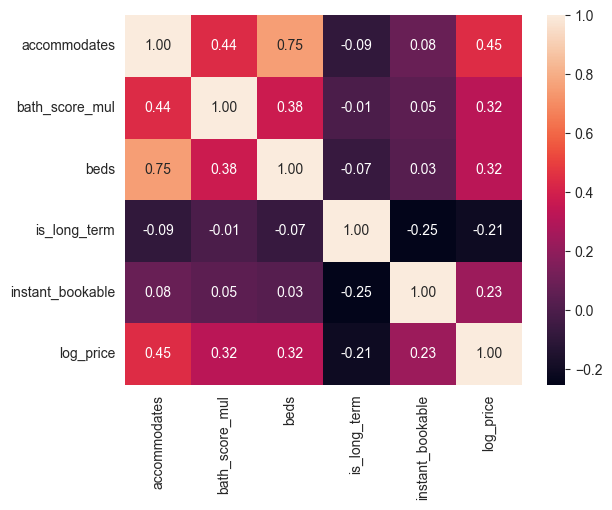

In [93]:
# 1) 숫자형 피처 리스트
num_feats = ['accommodates', 'bath_score_mul', 'beds', 'is_long_term', 'instant_bookable']

# 2) 상관행렬 계산
corr_df = df[num_feats + ['log_price']].corr()
sns.heatmap(corr_df, annot=True, fmt=".2f")


<Axes: >

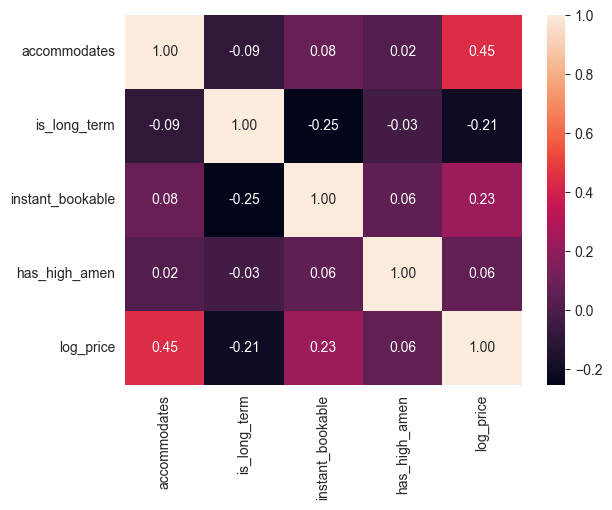

In [150]:
# 1) 숫자형 피처 리스트
num_feats = ['accommodates', 'is_long_term', 'instant_bookable', 'has_high_amen']

# 2) 상관행렬 계산
corr_df = df[num_feats + ['log_price']].corr()
sns.heatmap(corr_df, annot=True, fmt=".2f")


In [165]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 숫자형 피처만 사용
X_num = df[num_feats].values

vif_num = pd.DataFrame({
    'feature': num_feats,
    'VIF': [variance_inflation_factor(X_num, i)
            for i in range(X_num.shape[1])]
}).sort_values('VIF', ascending=False)

print(vif_num)


            feature       VIF
3     has_high_amen  5.686588
1      is_long_term  4.023304
0      accommodates  2.991882
2  instant_bookable  1.372646


In [105]:
df_enc = pd.get_dummies(df[features], drop_first=True)


In [152]:
# 1) get_dummies 시에 바로 float 타입으로
df_enc = pd.get_dummies(
    df[features],
    drop_first=True,
    dtype=float      # ← 여기 추가
)

# 2) 값을 float 배열로 추출
X_all = df_enc.values  # 이미 float

# 3) VIF 계산
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_all = pd.DataFrame({
    'feature': df_enc.columns,
    'VIF': [variance_inflation_factor(X_all, i)
            for i in range(X_all.shape[1])]
}).sort_values('VIF', ascending=False)

print(vif_all.head(10))


KeyError: "['room_type_ord'] not in index"

In [159]:

features = [
    'neigh_cluster_reduced', 'room_type_ord', 'room_new_type_ord',
    'accommodates',
    'is_long_term', 'instant_bookable', 'has_high_amen'
]

df_dummies = df_enc.drop(columns=num_feats)
X_dummy = df_dummies.values
vif_dummy = pd.DataFrame({
    'feature': df_dummies.columns,
    'VIF': [variance_inflation_factor(X_dummy, i)
            for i in range(X_dummy.shape[1])]
}).sort_values('VIF', ascending=False)
print(vif_dummy.head(10))


KeyError: "['has_high_amen'] not found in axis"

In [155]:
features = [
    'neigh_cluster_reduced', 'room_type_ord', 'room_new_type',
    'accommodates',
    'is_long_term', 'instant_bookable', 'has_high_amen'
]

In [160]:
df[features].head(10)

KeyError: "['room_type_ord'] not in index"

In [194]:
# 예: amen_grp
grp_order = {
    'low-mid': 1,
    'mid': 2,
    'upper-mid': 3,
    'high': 4
}
df['amen_grp_ord'] = df['amen_grp'].map(grp_order).astype(int)

# 예: room_new_type
rnt_order = {
    'low-mid': 0,
    'mid': 1,
    'upper-mid': 2
}
df['room_new_type_ord'] = df['room_new_type'].map(rnt_order).astype(int)


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [135]:
df['amen_grp'].unique()

['high', 'upper_mid', 'common', 'none', 'low_mid', 'mid']
Categories (6, object): ['common', 'high', 'low_mid', 'mid', 'none', 'upper_mid']

In [195]:
amen_order = {
    'none'      : 0,
    'low_mid'   : 2,
    'mid'       : 3,
    'common'    : 1,   # 'common'을 'mid'와 같은 수준으로 처리
    'upper_mid' : 4,
    'high'      : 5
}

# 2) 새로운 숫자형 컬럼 생성
df['amen_grp_ord'] = df['amen_grp'].map(amen_order).astype(int)

In [196]:
df['room_type'].unique()

room_order = {
    'Private room'      : 0,
    'Shared room'       : 1,
    'Entire home/apt'   : 2,
    'Hotel room'        : 3
}

df['room_type_ord'] = df['room_type'].map(room_order).astype(int)


In [197]:
rnt_order = {
    'low-mid': 0,
    'mid': 1,
    'upper-mid': 2,
    'high': 3
}
df['room_new_type_ord'] = df['room_new_type'].map(rnt_order).astype(int)

In [193]:
counts = df['neigh_cluster'].value_counts()

# 상위 3개만 남기고 나머지는 'other' 처리
top3 = counts.nlargest(4).index
df['neigh_cluster_reduced'] = df['neigh_cluster'].where(
    df['neigh_cluster'].isin(top3),
    other='other'
)

In [164]:
df['has_high_amen'] = (df['amen_grp'] == 'high').astype(int)


In [198]:
# 1) high amen 플래그 만들기
df['has_high_amen'] = (df['amen_grp'] == 'high').astype(int)

# 2) 기존 amen_grp 컬럼은 피처 리스트에서 제거
cat_cols = ['neigh_cluster_reduced', 'room_new_type_ord', 'room_type_ord']   # amen_grp 뺌
num_cols = ['accommodates']
bin_cols = ['is_long_term', 'instant_bookable', 'has_high_amen']  # 여기에 추가

# 3) 파이프라인 재구성
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols),
    ('num', StandardScaler(), num_cols),
    ('bin', 'passthrough', bin_cols)
])

pipe = Pipeline([
    ('pre', pre),
    ('reg', HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=6,
        l2_regularization=2.0,
        random_state=42
    ))
])

# 4) 학습·평가 예시
X = df[cat_cols + num_cols + bin_cols]
y = df['log_price']

pipe.fit(X, y)


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['neigh_cluster_reduced',
                                                   'room_new_type_ord',
                                                   'room_type_ord']),
                                                 ('num', StandardScaler(),
                                                  ['accommodates']),
                                                 ('bin', 'passthrough',
                                                  ['is_long_term',
                                                   'instant_bookable',
                                                   'has_high_amen'])])),
                ('reg',
                 HistGradientBoostingRegressor(l2_regularization=2.0,
                                               learning_rate=0.05, max_depth=6,
                                               random_state=42))])

In [223]:
# ──────────────────────────────────────────────
# 0) 라이브러리
# ──────────────────────────────────────────────
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ──────────────────────────────────────────────
# 1) 최종 피처 셋
# ──────────────────────────────────────────────
cat_cols = ['neigh_cluster', 'room_new_type_ord', 'room_type_ord', 'neighbourhood_group_cleansed', 'amen_grp']   # amen_grp 뺌
num_cols = ['accommodates', 'review_scores_rating']
bin_cols = ['is_long_term', 'instant_bookable', 'has_high_amen', 'host_is_superhost']

# has_high_amen 플래그 생성
if 'has_high_amen' not in df.columns:
    df['has_high_amen'] = (df['amen_grp'] == 'high').astype(int)

# ──────────────────────────────────────────────
# 2) 입력 데이터 정의 (전체 피처 사용)
# ──────────────────────────────────────────────
X = df[cat_cols + num_cols + bin_cols]
y = df['log_price']

# ──────────────────────────────────────────────
# 3) 전처리 + 모델
# ──────────────────────────────────────────────
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols),
    ('num', StandardScaler(), num_cols),
    ('bin', 'passthrough', bin_cols)
])

hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=6,
    l2_regularization=2.0,
    random_state=42
)

pipe = Pipeline([
    ('pre', pre),
    ('model', hgb)
])

# ──────────────────────────────────────────────
# 4) 5-fold CV (로그 RMSE)
# ──────────────────────────────────────────────
neg_rmse = cross_val_score(
    pipe,
    X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1        # 병렬 처리 끄기
)
cv_rmse_log = -neg_rmse.mean()
print(f"CV RMSE (log)   : {cv_rmse_log:.3f}")

# ──────────────────────────────────────────────
# 5) 홀드아웃 테스트 성능 (로그 & $)
# ──────────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df['room_type']
)

pipe.fit(X_tr, y_tr)
pred_log = pipe.predict(X_te)

rmse_log = mean_squared_error(y_te, pred_log, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log)

pred_ = np.expm1(pred_log)
true_ = np.expm1(y_te)
rmse_  = mean_squared_error(true_, pred_, squared=False)
mae_   = mean_absolute_error(true_, pred_)

print(f"TEST RMSE (log) : {rmse_log:.3f}")
print(f"TEST MAE  (log) : {mae_log:.3f}")
print(f"TEST RMSE ($)   : ${rmse_:,.2f}")
print(f"TEST MAE  ($)   : ${mae_ :,.2f}")

# ──────────────────────────────────────────────
# 6) 모델 저장
# ──────────────────────────────────────────────
joblib.dump(pipe, '../03_MachineLearning/price_predictor_redvars.joblib')
print("✅ saved → price_predictor_redvars.joblib")


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site

CV RMSE (log)   : 0.399


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}


TEST RMSE (log) : 0.394
TEST MAE  (log) : 0.301
TEST RMSE ($)   : $69.93
TEST MAE  ($)   : $46.72
✅ saved → price_predictor_redvars.joblib


In [224]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
R2   = r2_score(true_, pred_)
MAPE = mean_absolute_percentage_error(true_, pred_)*100
print(f"R² = {R2:.3f},  MAPE = {MAPE:.1f} %")

R² = 0.554,  MAPE = 34.8 %


In [214]:
df.columns

Index(['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'availability_60', 'availability_365',
       'instant_bookable', 'is_long_term', 'is_activate', 'amenities',
       'amenities_cnt', 'room_type', 'room_structure_type', 'accommodates',
       'bath_score_mul', 'beds', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'host_id',
       'name_length_group', 'description_length_group',
       'neighborhood_overview_exists', 'host_about_length_group',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_time_score', 'host_response_rate_score',
       'host_acceptance_rate_score', 'host_location_ny

In [220]:
# has_high_amen 플래그 생성
if 'has_high_amen' not in df.columns:
    df['has_high_amen'] = (df['amen_grp'] == 'high').astype(int)

# 최종 피처 리스트
features = [
    'neigh_cluster', 'room_new_type_ord', 'room_type_ord',
    'accommodates', 'is_long_term', 'instant_bookable', 'has_high_amen', 'neighbourhood_group_cleansed', 'review_scores_rating'
]

# 1) df_enc 재생성
df_enc = pd.get_dummies(df[features], drop_first=True, dtype=float)

# 2) 숫자형 컬럼 리스트
num_feats = ['accommodates', 'is_long_term', 'instant_bookable', 'has_high_amen', 'review_scores_rating']

# 3) 더미만 추출하여 VIF 계산
df_dummies = df_enc.drop(columns=num_feats)
X_dummy = df_dummies.values

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_dummy = pd.DataFrame({
    'feature': df_dummies.columns,
    'VIF': [variance_inflation_factor(X_dummy, i)
            for i in range(X_dummy.shape[1])]
}).sort_values('VIF', ascending=False)

print(vif_dummy.head(10))



                                  feature       VIF
8  neighbourhood_group_cleansed_Manhattan  7.668677
5                neigh_cluster_nbr_grp_04  5.227255
0                       room_new_type_ord  4.541892
7   neighbourhood_group_cleansed_Brooklyn  4.270356
2                neigh_cluster_nbr_grp_01  3.685061
6                neigh_cluster_nbr_grp_05  3.161105
4                neigh_cluster_nbr_grp_03  3.040689
9     neighbourhood_group_cleansed_Queens  2.839143
1                           room_type_ord  2.497911
3                neigh_cluster_nbr_grp_02  1.324498


In [221]:
# ──────────────────────────────────────────────
# 7) 다른 모델: Random Forest Regressor
# ──────────────────────────────────────────────
from sklearn.ensemble import RandomForestRegressor

# 1) Random Forest 모델 정의
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=1
)

# 2) 파이프라인 구성
pipe_rf = Pipeline([
    ('pre', pre),      # 기존에 정의한 ColumnTransformer
    ('model', rf)
])

# 3) 5-fold CV (로그 RMSE)
neg_rmse_rf = cross_val_score(
    pipe_rf,
    X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
cv_rmse_log_rf = -neg_rmse_rf.mean()
print(f"RF CV RMSE (log): {cv_rmse_log_rf:.3f}")

# 4) 홀드아웃 테스트 성능
pipe_rf.fit(X_tr, y_tr)
pred_log_rf = pipe_rf.predict(X_te)

rmse_log_rf = mean_squared_error(y_te, pred_log_rf, squared=False)
mae_log_rf  = mean_absolute_error(y_te, pred_log_rf)

pred_rf = np.expm1(pred_log_rf)
true_rf = np.expm1(y_te)
rmse_rf  = mean_squared_error(true_rf, pred_rf, squared=False)
mae_rf   = mean_absolute_error(true_rf, pred_rf)

print(f"RF TEST RMSE (log) : {rmse_log_rf:.3f}")
print(f"RF TEST MAE  (log) : {mae_log_rf:.3f}")
print(f"RF TEST RMSE ($)   : ${rmse_rf:,.2f}")
print(f"RF TEST MAE  ($)   : ${mae_rf:,.2f}")


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site

RF CV RMSE (log): 0.404


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  found_unknown = {}


RF TEST RMSE (log) : 0.390
RF TEST MAE  (log) : 0.297
RF TEST RMSE ($)   : $68.54
RF TEST MAE  ($)   : $45.75


In [222]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
R2   = r2_score(true_rf, pred_rf)
MAPE = mean_absolute_percentage_error(true_rf, pred_rf)*100
print(f"R² = {R2:.3f},  MAPE = {MAPE:.1f} %")

R² = 0.572,  MAPE = 32.5 %


In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20560 entries, 36121 to 1366723228243064949
Data columns (total 86 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   neighbourhood_cleansed                     20560 non-null  object  
 1   neighbourhood_group_cleansed               20560 non-null  object  
 2   latitude                                   20560 non-null  float64 
 3   longitude                                  20560 non-null  float64 
 4   price                                      20560 non-null  float64 
 5   estimated_occupancy_l365d                  20560 non-null  int64   
 6   estimated_revenue_l365d                    20560 non-null  float64 
 7   availability_60                            20560 non-null  int64   
 8   availability_365                           20560 non-null  int64   
 9   instant_bookable                           20560 non-null  int64   
 1

In [6]:
# ──────────────────────────────────────────────
# CatBoost Regressor (categoricalBoosting) 적용
# ──────────────────────────────────────────────
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1) 데이터: CatBoost는 범주형을 직접 처리하므로 인코딩 필요 없음

cat_cols = ['neigh_cluster', 'room_new_type', 'room_type', 'neighbourhood_group_cleansed', 'amen_grp']   # amen_grp 뺌
num_cols = ['accommodates', 'review_scores_rating', 'latitude', 'longitude', 'amenities_cnt', 'bath_score_mul', 'beds', 'number_of_reviews', 'description_length_group',  'host_about_length_group', 'host_response_rate_score', 'host_acceptance_rate_score']
bin_cols = ['is_long_term', 'instant_bookable', 'has_high_amen', 'host_is_superhost', 'neighborhood_overview_exists', 'is_activate']

X = df[cat_cols + num_cols + bin_cols]
y = df['log_price']

# 2) 범주형 컬럼 인덱스 지정
cat_features = [X.columns.get_loc(col) for col in cat_cols + bin_cols]

# 3) 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_log_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool   = Pool(X_val,   y_val,   cat_features=cat_features)

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3.0,
        loss_function='RMSE',
        random_seed=42,
        verbose=False
    )
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

    pred_log_val = model.predict(val_pool)
    rmse_log = mean_squared_error(y_val, pred_log_val, squared=False)
    rmse_log_scores.append(rmse_log)

print(f"CatBoost CV RMSE (log): {np.mean(rmse_log_scores):.3f}")

# 4) 최종 모델 학습 & 홀드아웃 테스트
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['room_type']
)

train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
test_pool  = Pool(X_te, y_te, cat_features=cat_features)

final_model = CatBoostRegressor(
    iterations=model.best_iteration_,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)
final_model.fit(train_pool, verbose=False)

pred_log = final_model.predict(test_pool)
rmse_log = mean_squared_error(y_te, pred_log, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log)

pred_ = np.expm1(pred_log)
true_ = np.expm1(y_te)
rmse_ = mean_squared_error(true_, pred_, squared=False)
mae_  = mean_absolute_error(true_, pred_)

print(f"CatBoost TEST RMSE (log) : {rmse_log:.3f}")
print(f"CatBoost TEST MAE  (log) : {mae_log:.3f}")
print(f"CatBoost TEST RMSE ($)   : ${rmse_:,.2f}")
print(f"CatBoost TEST MAE  ($)   : ${mae_ :,.2f}")

# 5) 모델 저장
final_model.save_model('price_predictor_catboost.cbm')
print("✅ saved → price_predictor_catboost.cbm")


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=13]="short_or_avg": Cannot convert 'short_or_avg' to float

In [5]:
import pandas as pd
df = pd.read_csv('/Users/hyeom/Documents/GitHub/advanced_project/hye_project/for_machine_learning.csv', header=0, index_col='id')

In [239]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
R2   = r2_score(true_, pred_)
MAPE = mean_absolute_percentage_error(true_, pred_)*100
print(f"R² = {R2:.3f},  MAPE = {MAPE:.1f} %")

R² = 0.679,  MAPE = 28.1 %


In [243]:
wonder = df.head(10)
print(wonder)

      neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
id                                                                     
36121       Prospect Heights                     Brooklyn  40.673760   
36647            East Harlem                    Manhattan  40.792454   
38833                 Harlem                    Manhattan  40.818058   
39282           Williamsburg                     Brooklyn  40.710651   
39572         Hell's Kitchen                    Manhattan  40.762030   
6848            Williamsburg                     Brooklyn  40.709350   
6872             East Harlem                    Manhattan  40.801070   
6990             East Harlem                    Manhattan  40.787780   
7097             Fort Greene                     Brooklyn  40.691940   
7801            Williamsburg                     Brooklyn  40.718807   

       longitude  price  estimated_occupancy_l365d  estimated_revenue_l365d  \
id                                                      

In [244]:
# (1) 한 번만 설정하면 현재 세션에서 계속 유지됩니다.
import pandas as pd

# 컬럼·행 생략 없이(full) 출력
pd.set_option('display.max_columns', None)  # 모든 컬럼 보이기
pd.set_option('display.max_rows',    None)  # 생략 없이 모든 행 보이기
pd.set_option('display.width',       None)  # 가로 너비 제한 해제
pd.set_option('display.max_colwidth', None) # 셀 안 문자열 생략 없음

# (2) 확인
wonder = df.head(10)
print(wonder)

      neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
id                                                                     
36121       Prospect Heights                     Brooklyn  40.673760   
36647            East Harlem                    Manhattan  40.792454   
38833                 Harlem                    Manhattan  40.818058   
39282           Williamsburg                     Brooklyn  40.710651   
39572         Hell's Kitchen                    Manhattan  40.762030   
6848            Williamsburg                     Brooklyn  40.709350   
6872             East Harlem                    Manhattan  40.801070   
6990             East Harlem                    Manhattan  40.787780   
7097             Fort Greene                     Brooklyn  40.691940   
7801            Williamsburg                     Brooklyn  40.718807   

       longitude  price  estimated_occupancy_l365d  estimated_revenue_l365d  \
id                                                      

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score)
from catboost import CatBoostRegressor, Pool

df['amen_grp_te'] = df['amen_grp_te'].astype(float)

# ────────────────────────────────
# 1) 피처 리스트
# ────────────────────────────────
cat_cols = [
    'neigh_cluster_reduced', 'neighbourhood_group_cleansed',
    'room_type_ord', 'room_new_type_ord', 'room_structure_type',
]

num_cols = [
    'latitude', 'longitude', 'accommodates', 'bath_score_mul',
    'amenities_cnt', 'review_scores_rating',
    'number_of_reviews', 'number_of_reviews_ltm',
]

bin_cols = [
    'instant_bookable', 'is_long_term', 'host_is_superhost',
    'has_high_amen', 'has_Wifi', 'has_Air_conditioning',
    'has_Bathtub', 'has_Carbon_monoxide_alarm', 'has_Elevator'
]

te_cols = ['amen_grp_te']          # target-encoding 결과 컬럼

features = cat_cols + num_cols + bin_cols + te_cols
target   = 'log_price'

X = df[features]
y = df[target]

# CatBoost에 넘길 범주형 컬럼 인덱스
cat_features = [X.columns.get_loc(c) for c in cat_cols + bin_cols]

# ────────────────────────────────
# 2) 5-fold CV
# ────────────────────────────────
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores, r2_scores = [], []

for tr_idx, val_idx in kf.split(X):
    train_pool = Pool(X.iloc[tr_idx], y.iloc[tr_idx],
                      cat_features=cat_features)
    val_pool   = Pool(X.iloc[val_idx], y.iloc[val_idx],
                      cat_features=cat_features)

    model = CatBoostRegressor(
        iterations=1200,
        learning_rate=0.05,
        depth=7,
        l2_leaf_reg=3.0,
        loss_function='RMSE',
        random_seed=42,
        verbose=False,
        early_stopping_rounds=80
    )
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    pred_val = model.predict(val_pool)
    rmse_scores.append(mean_squared_error(y.iloc[val_idx], pred_val, squared=False))
    r2_scores.append(r2_score(y.iloc[val_idx], pred_val))

print(f"CV RMSE (log)   : {np.mean(rmse_scores):.3f}")
print(f"CV R²           : {np.mean(r2_scores):.3f}")

# ────────────────────────────────
# 3) 홀드아웃 평가
# ────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=df['room_type_ord']  # 층화
)

train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
test_pool  = Pool(X_te, y_te, cat_features=cat_features)

final_model = CatBoostRegressor(**model.get_params())
final_model.fit(train_pool, verbose=False)

pred_log = final_model.predict(test_pool)

rmse_log = mean_squared_error(y_te, pred_log, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log)
r2       = r2_score(y_te, pred_log)

pred_ = np.expm1(pred_log)
true_ = np.expm1(y_te)

rmse_ = mean_squared_error(true_, pred_, squared=False)
mae_  = mean_absolute_error(true_, pred_)
mape  = np.mean(np.abs((true_ - pred_) / true_)) * 100

print("\n=== Hold-out Test ===")
print(f"RMSE (log)      : {rmse_log:.3f}")
print(f"MAE  (log)      : {mae_log:.3f}")
print(f"R²              : {r2:.3f}")
print(f"RMSE ($)        : ${rmse_:,.2f}")
print(f"MAE  ($)        : ${mae_:,.2f}")
print(f"MAPE            : {mape:.1f} %")

# ────────────────────────────────
# 4) 모델 저장
# ────────────────────────────────
print("✅ saved  → price_predictor_catboost.cbm")


CV RMSE (log)   : 0.325
CV R²           : 0.744

=== Hold-out Test ===
RMSE (log)      : 0.330
MAE  (log)      : 0.245
R²              : 0.736
RMSE ($)        : $56.84
MAE  ($)        : $37.25
MAPE            : 25.6 %
✅ saved  → price_predictor_catboost.cbm


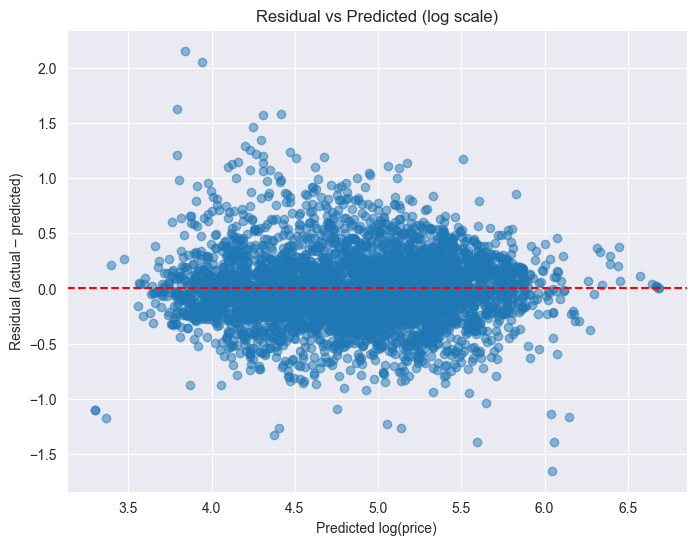

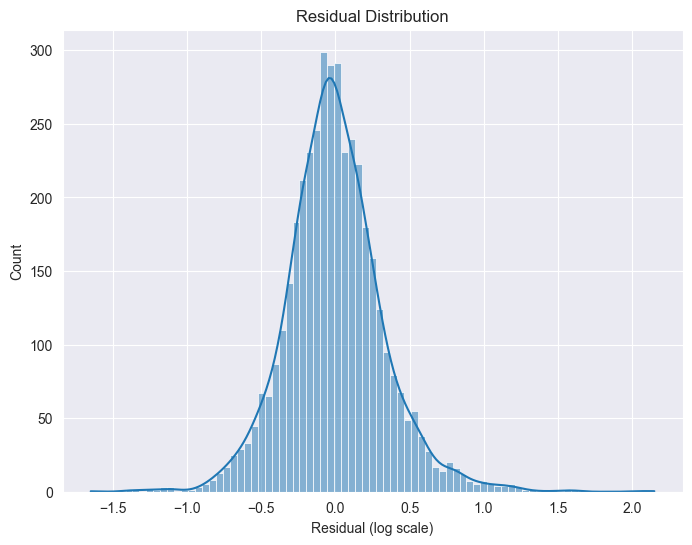

가격 구간별 평균 절대오차 (달러):
decile
0    16.161056
1    15.961709
2    22.450449
3    26.976085
4    28.468452
5    32.326015
6    34.266227
7    44.409244
8    61.018333
9    91.616736
Name: MAE_$, dtype: float64

지역(클러스터)별 평균 잔차 ($):
neigh
nbr_grp_05    26.484663
other         28.009074
nbr_grp_03    33.845497
nbr_grp_04    42.553123
nbr_grp_01    52.353667
Name: residual_$, dtype: float64


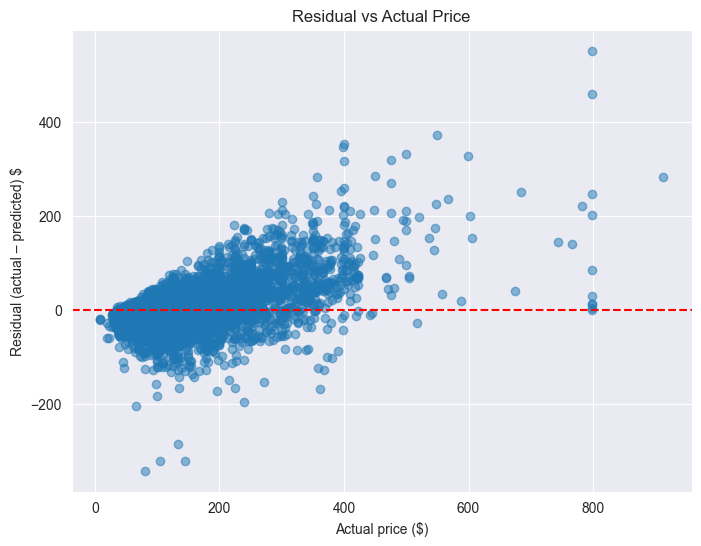

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 예측 및 잔차 계산
# final_model, X_te, y_te, pred_log 가 이미 정의되어 있다고 가정
residuals_log = y_te - pred_log
residuals_   = np.expm1(y_te) - np.expm1(pred_log)

# 2) Predicted vs Residual (로그)
plt.figure(figsize=(8,6))
plt.scatter(pred_log, residuals_log, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log(price)')
plt.ylabel('Residual (actual – predicted)')
plt.title('Residual vs Predicted (log scale)')
plt.show()

# 3) Residual 분포 확인
plt.figure(figsize=(8,6))
sns.histplot(residuals_log, kde=True)
plt.xlabel('Residual (log scale)')
plt.title('Residual Distribution')
plt.show()

# 4) 가격 구간별 평균 절대오차 (달러)
df_res = X_te.copy()
df_res['residual_$'] = np.abs(residuals_)
df_res['actual_$']   = np.expm1(y_te)
df_res['decile']     = pd.qcut(df_res['actual_$'], 10, labels=False)

mae_by_decile = df_res.groupby('decile')['residual_$'].mean().rename('MAE_$')
print("가격 구간별 평균 절대오차 (달러):")
print(mae_by_decile)

# 5) 군집별(지역별) 편향 확인
df_res['neigh'] = X_te['neigh_cluster_reduced']
bias_by_cluster = df_res.groupby('neigh')['residual_$'].mean().sort_values()
print("\n지역(클러스터)별 평균 잔차 ($):")
print(bias_by_cluster)

# 6) 잔차 vs 실제 가격 산점
plt.figure(figsize=(8,6))
plt.scatter(df_res['actual_$'], residuals_, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual price ($)')
plt.ylabel('Residual (actual – predicted) $')
plt.title('Residual vs Actual Price')
plt.show()


In [250]:
import numpy as np
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor, Pool

# ──────────────────────────────────────────────
# 0) 원본 타깃(Box–Cox 전)을 복원
# ──────────────────────────────────────────────
# log_price → 원단위 price
y_orig = np.expm1(df['log_price'])

# ──────────────────────────────────────────────
# 1) Box–Cox 변환 (λ, 양수 조건 주의)
# ──────────────────────────────────────────────
# 작은 양수 shift를 더해 0 회피
y_bc, lam = boxcox(y_orig + 1e-6)
df['price_bc'] = y_bc

# ──────────────────────────────────────────────
# 역변환 함수 직접 구현
# ──────────────────────────────────────────────
def inv_boxcox(y_bc, lam):
    if lam == 0:
        return np.exp(y_bc)
    else:
        return np.power(y_bc * lam + 1, 1.0 / lam)

# ──────────────────────────────────────────────
# 2) 학습/검증 데이터 준비
# ──────────────────────────────────────────────
features = cat_cols + num_cols + bin_cols + te_cols
X = df[features]

# CatBoost에 넘길 범주형 컬럼 인덱스
cat_features = [X.columns.get_loc(c) for c in cat_cols + bin_cols]

# ──────────────────────────────────────────────
# 3) 5-fold CV
# ──────────────────────────────────────────────
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_bc, r2_bc = [], []

for tr_idx, val_idx in kf.split(X):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr_bc      = df.loc[X_tr.index, 'price_bc']
    y_val_bc     = df.loc[X_val.index, 'price_bc']

    train_pool = Pool(X_tr, y_tr_bc, cat_features=cat_features)
    val_pool   = Pool(X_val, y_val_bc, cat_features=cat_features)

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=7,
        l2_leaf_reg=3.0,
        loss_function='RMSE',
        random_seed=42,
        verbose=False,
        early_stopping_rounds=50
    )
    model.fit(train_pool, eval_set=val_pool, verbose=False)

    # BC 공간 예측 → 역변환 → log 스케일로 비교
    pred_bc_val   = model.predict(val_pool)
    pred_price_val = inv_boxcox(pred_bc_val, lam)
    pred_log_val   = np.log(pred_price_val)

    true_price_val = inv_boxcox(y_val_bc.values, lam)
    true_log_val   = np.log(true_price_val)

    rmse_bc.append(mean_squared_error(true_log_val, pred_log_val, squared=False))
    r2_bc.append(r2_score(true_log_val, pred_log_val))

print(f"Box–Cox CV RMSE (log): {np.mean(rmse_bc):.3f}")
print(f"Box–Cox CV R²      : {np.mean(r2_bc):.3f}")

# ──────────────────────────────────────────────
# 4) 홀드아웃 평가
# ──────────────────────────────────────────────
X_tr, X_te, y_tr_bc, y_te_bc = train_test_split(
    X, df['price_bc'],
    test_size=0.2, random_state=42,
    stratify=df['room_type_ord']
)

train_pool = Pool(X_tr, y_tr_bc, cat_features=cat_features)
test_pool  = Pool(X_te, y_te_bc, cat_features=cat_features)

final_model = CatBoostRegressor(**model.get_params())
final_model.fit(train_pool, verbose=False)

# 예측 → 역변환
pred_bc_te    = final_model.predict(test_pool)
pred_price_te = inv_boxcox(pred_bc_te, lam)
pred_log_te   = np.log(pred_price_te)

true_price_te = y_orig[X_te.index]       # 원단위 actual
true_log_te   = np.log(true_price_te)

# 지표 계산
rmse_log = mean_squared_error(true_log_te, pred_log_te, squared=False)
mae_log  = mean_absolute_error(true_log_te, pred_log_te)
r2_val   = r2_score(true_log_te, pred_log_te)

rmse_ = mean_squared_error(true_price_te, pred_price_te, squared=False)
mae_  = mean_absolute_error(true_price_te, pred_price_te)
mape  = np.mean(np.abs((true_price_te - pred_price_te) / true_price_te)) * 100

print("\n=== Hold-out Test (Box–Cox) ===")
print(f"TEST RMSE (log) : {rmse_log:.3f}")
print(f"TEST MAE  (log) : {mae_log:.3f}")
print(f"TEST R²        : {r2_val:.3f}")
print(f"TEST RMSE ($)   : ${rmse_:,.2f}")
print(f"TEST MAE  ($)   : ${mae_ :,.2f}")
print(f"TEST MAPE       : {mape:.1f} %")

Box–Cox CV RMSE (log): 0.329
Box–Cox CV R²      : 0.741

=== Hold-out Test (Box–Cox) ===
TEST RMSE (log) : 0.334
TEST MAE  (log) : 0.249
TEST R²        : 0.734
TEST RMSE ($)   : $57.14
TEST MAE  ($)   : $37.44
TEST MAPE       : 25.9 %


In [251]:
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ──────────────────────────────────────
# 1) 가중치 계산 (price 기반)
# ──────────────────────────────────────
# 원단위 price
price = np.expm1(df['log_price'])
# 평균보다 비율이 클수록 가중치 증가 (제곱근 스케일)
weights = np.sqrt(price / price.mean())

# ──────────────────────────────────────
# 2) 데이터 분할
# ──────────────────────────────────────
features = cat_cols + num_cols + bin_cols + te_cols
X = df[features]
y = df['log_price']

X_tr, X_te, y_tr, y_te, w_tr, w_te = train_test_split(
    X, y, weights,
    test_size=0.2, random_state=42,
    stratify=df['room_type_ord']
)

# ──────────────────────────────────────
# 3) Pool 생성에 가중치 포함
# ──────────────────────────────────────
cat_feats_idx = [X.columns.get_loc(c) for c in cat_cols + bin_cols]

train_pool = Pool(X_tr, y_tr, weight=w_tr, cat_features=cat_feats_idx)
test_pool  = Pool(X_te, y_te, weight=w_te, cat_features=cat_feats_idx)

# ──────────────────────────────────────
# 4) 모델 학습
# ──────────────────────────────────────
model_w = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=3.0,
    loss_function='RMSE',
    random_seed=42,
    verbose=False,
    early_stopping_rounds=50
)
model_w.fit(train_pool, eval_set=test_pool, verbose=False)

# ──────────────────────────────────────
# 5) 평가
# ──────────────────────────────────────
pred_log_te = model_w.predict(test_pool)
pred_price_te = np.expm1(pred_log_te)
true_price_te = price[X_te.index]

rmse_log = mean_squared_error(y_te, pred_log_te, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log_te)
r2       = r2_score(y_te, pred_log_te)

rmse_     = mean_squared_error(true_price_te, pred_price_te, squared=False)
mae_      = mean_absolute_error(true_price_te, pred_price_te)
mape      = np.mean(np.abs((true_price_te - pred_price_te) / true_price_te)) * 100

print("Weighted‐Loss CatBoost")
print(f"R² (log)       : {r2:.3f}")
print(f"RMSE (log)     : {rmse_log:.3f}")
print(f"MAE  (log)     : {mae_log:.3f}")
print(f"RMSE ($)       : ${rmse_:,.2f}")
print(f"MAE  ($)       : ${mae_:,.2f}")
print(f"MAPE           : {mape:.1f} %")


Weighted‐Loss CatBoost
R² (log)       : 0.714
RMSE (log)     : 0.343
MAE  (log)     : 0.255
RMSE ($)       : $56.60
MAE  ($)       : $38.15
MAPE           : 29.1 %


In [260]:
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)

# ──────────────────────────────────────
# 1) 원단위 price 복원
# ──────────────────────────────────────
price = np.expm1(df['log_price'])

# ──────────────────────────────────────
# 2) 클러스터×고가 상호작용 변수 생성
# ──────────────────────────────────────
threshold = 100  # 원하는 고가 기준을 조정하세요
df['grp01_high'] = ((df['neigh_cluster_reduced']=='nbr_grp_01') & (price > threshold)).astype(int)
df['grp04_high'] = ((df['neigh_cluster_reduced']=='nbr_grp_04') & (price > threshold)).astype(int)

# ──────────────────────────────────────
# 3) 피처 리스트에 추가
# ──────────────────────────────────────
bin_cols2 = bin_cols + ['grp01_high', 'grp04_high']  # 기존 이진 피처에 합치기
features2 = cat_cols + num_cols + bin_cols2 + te_cols
X = df[features2]
y = df['log_price']

# CatBoost 범주형 인덱스 재계산
cat_feats_idx = [X.columns.get_loc(c) for c in cat_cols + ['instant_bookable','is_long_term','host_is_superhost','has_high_amen']]

# ──────────────────────────────────────
# 4) 학습/평가
# ──────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=df['room_type_ord']
)

train_pool = Pool(X_tr, y_tr, cat_features=cat_feats_idx)
test_pool  = Pool(X_te, y_te, cat_features=cat_feats_idx)

model2 = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=3.0,
    loss_function='RMSE',
    random_seed=42,
    verbose=False,
    early_stopping_rounds=50
)
model2.fit(train_pool, eval_set=test_pool, verbose=False)

pred_log_te = model2.predict(test_pool)
pred_price_te = np.expm1(pred_log_te)
true_price_te = price[X_te.index]

# 지표 계산
rmse_log = mean_squared_error(y_te, pred_log_te, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log_te)
r2_val   = r2_score(y_te, pred_log_te)

rmse_ = mean_squared_error(true_price_te, pred_price_te, squared=False)
mae_  = mean_absolute_error(true_price_te, pred_price_te)
mape  = np.mean(np.abs((true_price_te - pred_price_te) / true_price_te)) * 100

print("=== Cluster×High Interaction CatBoost ===")
print(f"R² (log)       : {r2_val:.3f}")
print(f"RMSE (log)     : {rmse_log:.3f}")
print(f"MAE  (log)     : {mae_log:.3f}")
print(f"RMSE ($)       : ${rmse_:,.2f}")
print(f"MAE  ($)       : ${mae_:,.2f}")
print(f"MAPE           : {mape:.1f} %")


=== Cluster×High Interaction CatBoost ===
R² (log)       : 0.760
RMSE (log)     : 0.315
MAE  (log)     : 0.235
RMSE ($)       : $55.83
MAE  ($)       : $36.17
MAPE           : 24.4 %


In [ ]:
# threshold 100
R² (log)       : 0.760
RMSE (log)     : 0.315
MAE  (log)     : 0.235
RMSE ($)       : $55.83
MAE  ($)       : $36.17
MAPE           : 24.4 %

# threshold 150
R² (log)       : 0.789
RMSE (log)     : 0.295
MAE  (log)     : 0.218
RMSE ($)       : $50.72
MAE  ($)       : $32.91
MAPE           : 22.4 %

# threshold 200
R² (log)       : 0.789
RMSE (log)     : 0.295
MAE  (log)     : 0.218
RMSE ($)       : $48.23
MAE  ($)       : $32.00
MAPE           : 22.6 %

# threshold 230
R² (log)       : 0.782
RMSE (log)     : 0.299
MAE  (log)     : 0.221
RMSE ($)       : $47.81
MAE  ($)       : $32.05
MAPE           : 22.9 %

# threshold 250
R² (log)       : 0.778
RMSE (log)     : 0.303
MAE  (log)     : 0.224
RMSE ($)       : $48.06
MAE  ($)       : $32.41
MAPE           : 23.2 %

# threshold 300
R² (log)       : 0.763
RMSE (log)     : 0.313
MAE  (log)     : 0.232
RMSE ($)       : $49.26
MAE  ($)       : $33.47
MAPE           : 24.0 %

# threshold 350
R² (log)       : 0.751
RMSE (log)     : 0.320
MAE  (log)     : 0.239
RMSE ($)       : $51.28
MAE  ($)       : $34.90
MAPE           : 24.8 %

# threshold 400
R² (log)       : 0.744
RMSE (log)     : 0.325
MAE  (log)     : 0.243
RMSE ($)       : $52.62
MAE  ($)       : $36.04
MAPE           : 25.3 %

In [262]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 0) price를 pandas Series로 보장
price = pd.Series(np.expm1(df['log_price']).values, index=df.index)

# 1) 기본 feature 목록
base_cols = (
    cat_cols
    + num_cols
    + ['instant_bookable','is_long_term','host_is_superhost','has_high_amen']
    + te_cols
)

def eval_thresholds(th_range):
    records = []
    for thr in th_range:
        # 상호작용 플래그
        df['grp01_high'] = ((df['neigh_cluster_reduced']=='nbr_grp_01') & (price > thr)).astype(int)
        df['grp04_high'] = ((df['neigh_cluster_reduced']=='nbr_grp_04') & (price > thr)).astype(int)

        features = base_cols + ['grp01_high','grp04_high']
        X = df[features]
        y = df['log_price']

        # 위치 기반 인덱스 배열
        idxs = np.arange(len(df))
        tr, te = train_test_split(
            idxs, test_size=0.2, random_state=42,
            stratify=df['room_type_ord']
        )

        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        # CatBoost Pool
        cat_idx = [
            X.columns.get_loc(c) for c in
            cat_cols + ['instant_bookable','is_long_term','host_is_superhost','has_high_amen','grp01_high','grp04_high']
        ]
        train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
        test_pool  = Pool(X_te, y_te, cat_features=cat_idx)

        model = CatBoostRegressor(
            iterations=800,
            learning_rate=0.05,
            depth=7,
            l2_leaf_reg=3.0,
            loss_function='RMSE',
            random_seed=42,
            verbose=False,
            early_stopping_rounds=30
        )
        model.fit(train_pool, eval_set=test_pool, verbose=False)

        pred_log     = model.predict(test_pool)
        pred_price   = np.expm1(pred_log)
        true_price   = price.iloc[te]          # ← .iloc 사용!

        r2   = r2_score(y_te, pred_log)
        rmse = mean_squared_error(y_te, pred_log, squared=False)
        mape = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

        records.append((thr, r2, rmse, mape))

    return pd.DataFrame(records, columns=['threshold','R2','RMSE_log','MAPE_%'])

# 이제 다시 돌려보세요
df_results1 = eval_thresholds(np.arange(120, 221, 10))
print("=== 120~220 (step=10) ===")
print(df_results1)

best_thr    = df_results1.loc[df_results1['R2'].idxmax(),'threshold']
search_rng  = np.arange(max(140, best_thr-20), min(180, best_thr+20)+1, 5)
df_results2 = eval_thresholds(search_rng)
print("\n=== 근접 140~180 (step=5) ===")
print(df_results2)



=== 120~220 (step=10) ===
    threshold        R2  RMSE_log     MAPE_%
0         120  0.767010  0.309832  23.942558
1         130  0.775037  0.304448  23.425066
2         140  0.779237  0.301593  23.142600
3         150  0.782845  0.299118  22.898122
4         160  0.784660  0.297866  22.806310
5         170  0.784458  0.298005  22.876784
6         180  0.783978  0.298337  22.917102
7         190  0.783481  0.298680  23.007273
8         200  0.781935  0.299744  23.046734
9         210  0.781712  0.299898  23.076582
10        220  0.780915  0.300445  23.090411

=== 근접 140~180 (step=5) ===
   threshold        R2  RMSE_log     MAPE_%
0        140  0.779237  0.301593  23.142600
1        145  0.779514  0.301404  23.078350
2        150  0.782845  0.299118  22.898122
3        155  0.783660  0.298556  22.833452
4        160  0.784660  0.297866  22.806310
5        165  0.785064  0.297586  22.784296
6        170  0.784458  0.298005  22.876784
7        175  0.785326  0.297405  22.845835
8        

In [264]:
# 1) price 복원
price = np.expm1(df['log_price'])

# 2) 최적 threshold 적용 (여기서는 165)
thr = 165
df['grp01_high'] = ((df['neigh_cluster_reduced']=='nbr_grp_01') & (price>thr)).astype(int)
df['grp04_high'] = ((df['neigh_cluster_reduced']=='nbr_grp_04') & (price>thr)).astype(int)

# 3) 피처 셋 정의
features_final = base_cols + ['grp01_high','grp04_high']
X = df[features_final]
y = df['log_price']

# 4) 학습·테스트 분할
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=df['room_type_ord']
)

# 5) CatBoost 학습
model_final = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=3.0,
    loss_function='RMSE',
    random_seed=42,
    verbose=False,
    early_stopping_rounds=50
)
model_final.fit(train_pool, eval_set=test_pool, verbose=False)

# 6) 최종 성능 확인
pred_log   = model_final.predict(test_pool)
pred_price = np.expm1(pred_log)

# 수정: .iloc → .loc 로 레이블 기반 인덱싱
true_price = price.loc[X_te.index]

rmse_log = mean_squared_error(y_te, pred_log, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log)
r2_val   = r2_score(y_te, pred_log)

rmse_ = mean_squared_error(true_price, pred_price, squared=False)
mae_  = mean_absolute_error(true_price, pred_price)
mape  = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

print("=== Final Model (thr=165) ===")
print(f"R² (log)   : {r2_val:.3f}")
print(f"RMSE (log) : {rmse_log:.3f}")
print(f"MAE  (log) : {mae_log:.3f}")
print(f"RMSE ($)   : ${rmse_:,.2f}")
print(f"MAE  ($)   : ${mae_:,.2f}")
print(f"MAPE       : {mape:.1f} %")


=== Final Model (thr=165) ===
R² (log)   : 0.787
RMSE (log) : 0.296
MAE  (log) : 0.219
RMSE ($)   : $50.52
MAE  ($)   : $32.99
MAPE       : 22.6 %


In [267]:
import optuna
from catboost import cv

# 데이터 및 카테고리 인덱스 준비
features_final = base_cols + ['grp01_high','grp04_high']
X = df[features_final]
y = df['log_price']
cat_features = [X.columns.get_loc(c) for c in cat_cols + ['instant_bookable','is_long_term','host_is_superhost','has_high_amen','grp01_high','grp04_high']]

# Optuna objective 함수
def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('lr', 1e-3, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2', 1e-1, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bt', 0.0, 1.0),
        'loss_function': 'RMSE',
        'random_seed': 42,
        'verbose': False
    }
    pool = Pool(X, y, cat_features=cat_features)
    cv_data = cv(pool, params, fold_count=5, early_stopping_rounds=50, verbose=False)
    # return 최종 test-RMSE-mean
    return float(cv_data['test-RMSE-mean'].iloc[-1])

# Optuna 스터디 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best CV RMSE(log):", study.best_value)


[I 2025-07-21 19:16:47,717] A new study created in memory with name: no-name-0f803abc-3283-4156-ac62-28d533fca727


Training on fold [0/5]

bestTest = 0.4012116944
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4028108199
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4148386201
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4047368628
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:18:28,185] Trial 0 finished with value: 0.40712693703339775 and parameters: {'lr': 0.0031877666520422664, 'depth': 9, 'l2': 0.3480817625584853, 'bt': 0.8723198211004313}. Best is trial 0 with value: 0.40712693703339775.



bestTest = 0.412036688
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3050100618
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2985873999
bestIteration = 997

Training on fold [2/5]

bestTest = 0.3032073343
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3023928205
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:18:55,889] Trial 1 finished with value: 0.30285114679236164 and parameters: {'lr': 0.037496110579525996, 'depth': 5, 'l2': 5.478965246809307, 'bt': 0.5528855022050854}. Best is trial 1 with value: 0.30285114679236164.



bestTest = 0.30505718
bestIteration = 998

Training on fold [0/5]

bestTest = 0.7546486998
bestIteration = 999

Training on fold [1/5]

bestTest = 0.7550090408
bestIteration = 999

Training on fold [2/5]

bestTest = 0.7801441267
bestIteration = 999

Training on fold [3/5]

bestTest = 0.758186274
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:19:18,573] Trial 2 finished with value: 0.7649374458785232 and parameters: {'lr': 0.002040908427511296, 'depth': 4, 'l2': 7.551550200400025, 'bt': 0.6530031564821234}. Best is trial 1 with value: 0.30285114679236164.



bestTest = 0.7766990882
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3082609771
bestIteration = 999

Training on fold [1/5]

bestTest = 0.303662944
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3092372289
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3070450554
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:19:53,766] Trial 3 finished with value: 0.30730548799403506 and parameters: {'lr': 0.015707845911253352, 'depth': 6, 'l2': 3.163865466214819, 'bt': 0.45598844309616415}. Best is trial 1 with value: 0.30285114679236164.



bestTest = 0.3083212346
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3209939163
bestIteration = 999

Training on fold [1/5]

bestTest = 0.3200588234
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3238264377
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3215871507
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:20:41,257] Trial 4 finished with value: 0.3221355947528691 and parameters: {'lr': 0.005959341524866562, 'depth': 7, 'l2': 0.9169550746489987, 'bt': 0.3181098194852532}. Best is trial 1 with value: 0.30285114679236164.



bestTest = 0.3242116456
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2949057757
bestIteration = 997

Training on fold [1/5]

bestTest = 0.2845857734
bestIteration = 998

Training on fold [2/5]

bestTest = 0.2919079824
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2915644547
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:21:44,147] Trial 5 finished with value: 0.29119121676264675 and parameters: {'lr': 0.05254341269876878, 'depth': 7, 'l2': 0.16741697991099372, 'bt': 0.9018992827812158}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2929689826
bestIteration = 998

Training on fold [0/5]

bestTest = 0.2976899792
bestIteration = 997

Training on fold [1/5]

bestTest = 0.2879823283
bestIteration = 999

Training on fold [2/5]

bestTest = 0.295382501
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2946572366
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:22:51,876] Trial 6 finished with value: 0.29438995958782843 and parameters: {'lr': 0.03166540420009055, 'depth': 7, 'l2': 0.49514410641482764, 'bt': 0.5371534808554123}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2962292006
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3035878014
bestIteration = 997

Training on fold [1/5]

bestTest = 0.2957193245
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3014298445
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3009087958
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:23:33,474] Trial 7 finished with value: 0.30073469960541127 and parameters: {'lr': 0.06786157926031569, 'depth': 4, 'l2': 0.16013833188464302, 'bt': 0.9284559800088876}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.3019999258
bestIteration = 997

Training on fold [0/5]

bestTest = 0.3127173521
bestIteration = 999

Training on fold [1/5]

bestTest = 0.3081639562
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3133114474
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3104988081
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:25:35,858] Trial 8 finished with value: 0.31149090902860826 and parameters: {'lr': 0.007892454045540759, 'depth': 9, 'l2': 3.4652134169622957, 'bt': 0.867863967813783}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.3127629814
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3823522986
bestIteration = 999

Training on fold [1/5]

bestTest = 0.3804165343
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3945840348
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3841670072
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:26:36,096] Trial 9 finished with value: 0.38600622332950085 and parameters: {'lr': 0.003533540764396221, 'depth': 10, 'l2': 7.277629467372217, 'bt': 0.7774367930703217}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.3885112417
bestIteration = 999

Training on fold [0/5]

bestTest = 0.295716839
bestIteration = 240

Training on fold [1/5]

bestTest = 0.2873049929
bestIteration = 404

Training on fold [2/5]

bestTest = 0.2950024953
bestIteration = 448

Training on fold [3/5]

bestTest = 0.293443335
bestIteration = 458

Training on fold [4/5]


[I 2025-07-21 19:27:11,475] Trial 10 finished with value: 0.29368951902911833 and parameters: {'lr': 0.19218458060380242, 'depth': 8, 'l2': 0.12877630662704032, 'bt': 0.025739184568353668}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2953429604
bestIteration = 424

Training on fold [0/5]

bestTest = 0.2999003115
bestIteration = 195

Training on fold [1/5]

bestTest = 0.2893618334
bestIteration = 256

Training on fold [2/5]

bestTest = 0.2958791193
bestIteration = 340

Training on fold [3/5]

bestTest = 0.2965875039
bestIteration = 276

Training on fold [4/5]


[I 2025-07-21 19:27:36,793] Trial 11 finished with value: 0.2961137510185627 and parameters: {'lr': 0.19825508272182069, 'depth': 8, 'l2': 0.11743598266150135, 'bt': 0.009014042040003008}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2966604226
bestIteration = 204

Training on fold [0/5]

bestTest = 0.3006950614
bestIteration = 171

Training on fold [1/5]

bestTest = 0.2904469778
bestIteration = 315

Training on fold [2/5]

bestTest = 0.2953867514
bestIteration = 424

Training on fold [3/5]

bestTest = 0.2931991928
bestIteration = 390

Training on fold [4/5]


[I 2025-07-21 19:28:07,249] Trial 12 finished with value: 0.2951629787944684 and parameters: {'lr': 0.18568210427198764, 'depth': 8, 'l2': 0.24844326022246957, 'bt': 0.021219732893470317}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2937032043
bestIteration = 406

Training on fold [0/5]

bestTest = 0.2973508766
bestIteration = 962

Training on fold [1/5]

bestTest = 0.2878044481
bestIteration = 967

Training on fold [2/5]

bestTest = 0.2941383453
bestIteration = 998

Training on fold [3/5]

bestTest = 0.293466079
bestIteration = 990

Training on fold [4/5]


[I 2025-07-21 19:28:55,441] Trial 13 finished with value: 0.29311362286304316 and parameters: {'lr': 0.082504453371726, 'depth': 6, 'l2': 0.10464591456558055, 'bt': 0.22639689286990328}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2924515464
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2960864392
bestIteration = 992

Training on fold [1/5]

bestTest = 0.2866539944
bestIteration = 999

Training on fold [2/5]

bestTest = 0.292807146
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2938128481
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:29:55,044] Trial 14 finished with value: 0.29277071296016355 and parameters: {'lr': 0.07837859080350602, 'depth': 6, 'l2': 1.2334082682497094, 'bt': 0.270550148419409}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2944375221
bestIteration = 987

Training on fold [0/5]

bestTest = 0.2980976036
bestIteration = 997

Training on fold [1/5]

bestTest = 0.2884901896
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2953446426
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2942615796
bestIteration = 995

Training on fold [4/5]


[I 2025-07-21 19:30:42,807] Trial 15 finished with value: 0.2942501764753136 and parameters: {'lr': 0.06942784090173448, 'depth': 6, 'l2': 1.5212464984765963, 'bt': 0.3565134530789882}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2950347866
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3069153481
bestIteration = 999

Training on fold [1/5]

bestTest = 0.3011069771
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3057156263
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3042869788
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:31:19,381] Trial 16 finished with value: 0.3050457825347698 and parameters: {'lr': 0.02304075494016618, 'depth': 5, 'l2': 0.8697377164067439, 'bt': 0.1873727316938736}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.3072039823
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3015883214
bestIteration = 995

Training on fold [1/5]

bestTest = 0.2944280565
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3005210153
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2988361767
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:31:59,615] Trial 17 finished with value: 0.29921280607955864 and parameters: {'lr': 0.04731854895954574, 'depth': 5, 'l2': 1.7790521112998678, 'bt': 0.703897024998311}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.3006754973
bestIteration = 998

Training on fold [0/5]

bestTest = 0.2949231707
bestIteration = 869

Training on fold [1/5]

bestTest = 0.284252985
bestIteration = 932

Training on fold [2/5]

bestTest = 0.2913096056
bestIteration = 713

Training on fold [3/5]

bestTest = 0.2933208334
bestIteration = 725

Training on fold [4/5]


[I 2025-07-21 19:32:51,090] Trial 18 finished with value: 0.2914429389733332 and parameters: {'lr': 0.10030157366392835, 'depth': 7, 'l2': 0.5770531795713901, 'bt': 0.4298981478301936}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2927663363
bestIteration = 919

Training on fold [0/5]

bestTest = 0.2970409139
bestIteration = 560

Training on fold [1/5]

bestTest = 0.2853947319
bestIteration = 683

Training on fold [2/5]

bestTest = 0.2919225285
bestIteration = 994

Training on fold [3/5]

bestTest = 0.2918400293
bestIteration = 861

Training on fold [4/5]


[I 2025-07-21 19:33:40,219] Trial 19 finished with value: 0.29204612247209644 and parameters: {'lr': 0.1160790452167701, 'depth': 7, 'l2': 0.5257554074137666, 'bt': 0.9923059851060545}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2934094373
bestIteration = 603

Training on fold [0/5]

bestTest = 0.2968714765
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2884531457
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2961732336
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2953758866
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:36:05,638] Trial 20 finished with value: 0.29477013643630956 and parameters: {'lr': 0.015450418158060898, 'depth': 9, 'l2': 0.23741743794059708, 'bt': 0.4441406010554238}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2969769398
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2977265872
bestIteration = 426

Training on fold [1/5]

bestTest = 0.2842187092
bestIteration = 713

Training on fold [2/5]

bestTest = 0.2917054533
bestIteration = 993

Training on fold [3/5]

bestTest = 0.2907691602
bestIteration = 997

Training on fold [4/5]


[I 2025-07-21 19:37:34,771] Trial 21 finished with value: 0.2915056859380017 and parameters: {'lr': 0.11522069869961699, 'depth': 7, 'l2': 0.5374653313155727, 'bt': 0.989366186020824}. Best is trial 5 with value: 0.29119121676264675.



bestTest = 0.2924836355
bestIteration = 975

Training on fold [0/5]

bestTest = 0.296143651
bestIteration = 510

Training on fold [1/5]

bestTest = 0.2838146169
bestIteration = 643

Training on fold [2/5]

bestTest = 0.2912285274
bestIteration = 658

Training on fold [3/5]

bestTest = 0.2912161459
bestIteration = 703

Training on fold [4/5]


[I 2025-07-21 19:38:54,727] Trial 22 finished with value: 0.2906152241981367 and parameters: {'lr': 0.11605935719381348, 'depth': 8, 'l2': 0.5815224223244414, 'bt': 0.7780326980835199}. Best is trial 22 with value: 0.2906152241981367.



bestTest = 0.2896055919
bestIteration = 761

Training on fold [0/5]

bestTest = 0.2962119261
bestIteration = 444

Training on fold [1/5]

bestTest = 0.2833173155
bestIteration = 580

Training on fold [2/5]

bestTest = 0.291671515
bestIteration = 493

Training on fold [3/5]

bestTest = 0.2915718986
bestIteration = 528

Training on fold [4/5]


[I 2025-07-21 19:39:44,181] Trial 23 finished with value: 0.290914562899914 and parameters: {'lr': 0.1115103933508516, 'depth': 8, 'l2': 0.2844501383037066, 'bt': 0.7627746653420001}. Best is trial 22 with value: 0.2906152241981367.



bestTest = 0.2909650412
bestIteration = 636

Training on fold [0/5]

bestTest = 0.2950242513
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2833851508
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2899321179
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2907376878
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:41:09,231] Trial 24 finished with value: 0.290323276467991 and parameters: {'lr': 0.04539026428452472, 'depth': 8, 'l2': 0.21999660563407586, 'bt': 0.7687875084811446}. Best is trial 24 with value: 0.290323276467991.



bestTest = 0.2925243512
bestIteration = 992

Training on fold [0/5]

bestTest = 0.2942889326
bestIteration = 988

Training on fold [1/5]

bestTest = 0.2829001438
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2905300816
bestIteration = 999

Training on fold [3/5]

bestTest = 0.291121901
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:43:44,928] Trial 25 finished with value: 0.2902900325148 and parameters: {'lr': 0.02268473784118256, 'depth': 10, 'l2': 0.3096804245941924, 'bt': 0.7601905397790175}. Best is trial 25 with value: 0.2902900325148.



bestTest = 0.2926007614
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2935435591
bestIteration = 992

Training on fold [1/5]

bestTest = 0.2826621695
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2912261497
bestIteration = 997

Training on fold [3/5]

bestTest = 0.2911795037
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:46:27,234] Trial 26 finished with value: 0.29012125943136874 and parameters: {'lr': 0.022877738570443177, 'depth': 10, 'l2': 0.35802256704631735, 'bt': 0.6564655275097604}. Best is trial 26 with value: 0.29012125943136874.



bestTest = 0.2919791147
bestIteration = 999

Training on fold [0/5]

bestTest = 0.300860172
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2930545865
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3008120707
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3000054611
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:48:33,268] Trial 27 finished with value: 0.29928509904752737 and parameters: {'lr': 0.009816275043140487, 'depth': 10, 'l2': 0.3498083524495759, 'bt': 0.6105581383995015}. Best is trial 26 with value: 0.29012125943136874.



bestTest = 0.3016932049
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2932374759
bestIteration = 997

Training on fold [1/5]

bestTest = 0.2819982228
bestIteration = 999

Training on fold [2/5]

bestTest = 0.290913232
bestIteration = 997

Training on fold [3/5]

bestTest = 0.290520215
bestIteration = 997

Training on fold [4/5]


[I 2025-07-21 19:50:36,779] Trial 28 finished with value: 0.28971719246317346 and parameters: {'lr': 0.022915678526048783, 'depth': 10, 'l2': 0.19647667108431402, 'bt': 0.6881600652152288}. Best is trial 28 with value: 0.28971719246317346.



bestTest = 0.2919052183
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2940411626
bestIteration = 998

Training on fold [1/5]

bestTest = 0.2835879161
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2919980105
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2912533211
bestIteration = 997

Training on fold [4/5]


[I 2025-07-21 19:52:42,538] Trial 29 finished with value: 0.2905557096936094 and parameters: {'lr': 0.021526949062077198, 'depth': 10, 'l2': 0.364347922240951, 'bt': 0.6381616334245146}. Best is trial 28 with value: 0.28971719246317346.



bestTest = 0.2918686071
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2935051499
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2825469853
bestIteration = 991

Training on fold [2/5]

bestTest = 0.2917829586
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2903445519
bestIteration = 997

Training on fold [4/5]


[I 2025-07-21 19:54:35,455] Trial 30 finished with value: 0.2898742666638787 and parameters: {'lr': 0.02451155188578066, 'depth': 10, 'l2': 0.17887975726743233, 'bt': 0.8337136640947336}. Best is trial 28 with value: 0.28971719246317346.



bestTest = 0.2911759959
bestIteration = 990

Training on fold [0/5]

bestTest = 0.2927707989
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2826606639
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2905082984
bestIteration = 996

Training on fold [3/5]

bestTest = 0.2900973153
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:56:26,872] Trial 31 finished with value: 0.2895108840613362 and parameters: {'lr': 0.023484917765121124, 'depth': 10, 'l2': 0.16019847724332034, 'bt': 0.8405052994148958}. Best is trial 31 with value: 0.2895108840613362.



bestTest = 0.2915026715
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3003255022
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2932483704
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3002983287
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2989742053
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 19:58:28,533] Trial 32 finished with value: 0.2987874574784759 and parameters: {'lr': 0.011184749682969624, 'depth': 9, 'l2': 0.1684290291395826, 'bt': 0.8343485516122459}. Best is trial 31 with value: 0.2895108840613362.



bestTest = 0.3010903719
bestIteration = 998

Training on fold [0/5]

bestTest = 0.2927327649
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2807070738
bestIteration = 993

Training on fold [2/5]

bestTest = 0.2901508872
bestIteration = 995

Training on fold [3/5]

bestTest = 0.2887294572
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 20:00:19,724] Trial 33 finished with value: 0.2885592194251436 and parameters: {'lr': 0.029638157326550202, 'depth': 10, 'l2': 0.19606413550385973, 'bt': 0.6927170960283114}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2904596832
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2928592265
bestIteration = 992

Training on fold [1/5]

bestTest = 0.2827116529
bestIteration = 998

Training on fold [2/5]

bestTest = 0.2905906117
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2903832053
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 20:02:32,384] Trial 34 finished with value: 0.2896052703998119 and parameters: {'lr': 0.032216078275237224, 'depth': 9, 'l2': 0.1915376615661811, 'bt': 0.5766344681726425}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.291452501
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2940765883
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2820706927
bestIteration = 998

Training on fold [2/5]

bestTest = 0.2912131054
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2905653578
bestIteration = 996

Training on fold [4/5]


[I 2025-07-21 20:04:44,871] Trial 35 finished with value: 0.28970583037189157 and parameters: {'lr': 0.03104915657024679, 'depth': 9, 'l2': 0.13675644859160452, 'bt': 0.5777208339419959}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.290556112
bestIteration = 996

Training on fold [0/5]

bestTest = 0.2933412537
bestIteration = 969

Training on fold [1/5]

bestTest = 0.2817635046
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2907117771
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2897525059
bestIteration = 998

Training on fold [4/5]


[I 2025-07-21 20:07:06,547] Trial 36 finished with value: 0.28925249597132296 and parameters: {'lr': 0.0341300768738239, 'depth': 9, 'l2': 0.10171470304250999, 'bt': 0.584932832024962}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2906551594
bestIteration = 999

Training on fold [0/5]

bestTest = 0.293650716
bestIteration = 998

Training on fold [1/5]

bestTest = 0.2813689472
bestIteration = 993

Training on fold [2/5]

bestTest = 0.2908136095
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2903920386
bestIteration = 997

Training on fold [4/5]


[I 2025-07-21 20:09:18,617] Trial 37 finished with value: 0.28930095073418727 and parameters: {'lr': 0.03611784209331928, 'depth': 9, 'l2': 0.10002528080153761, 'bt': 0.5163324343604064}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2902036279
bestIteration = 999

Training on fold [0/5]

bestTest = 1.163394209
bestIteration = 999

Training on fold [1/5]

bestTest = 1.158232073
bestIteration = 999

Training on fold [2/5]

bestTest = 1.186853662
bestIteration = 999

Training on fold [3/5]

bestTest = 1.165916853
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 20:10:40,764] Trial 38 finished with value: 1.171184024580268 and parameters: {'lr': 0.0015025583152512225, 'depth': 9, 'l2': 0.1042513828579658, 'bt': 0.5195715612105931}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 1.181523326
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2977496352
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2903061356
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2981904051
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2965651847
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 20:12:43,586] Trial 39 finished with value: 0.2963594193737314 and parameters: {'lr': 0.013123713948983597, 'depth': 9, 'l2': 0.1294701016681331, 'bt': 0.4928231636615019}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2989857363
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3144288021
bestIteration = 999

Training on fold [1/5]

bestTest = 0.3103979478
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3169405512
bestIteration = 999

Training on fold [3/5]

bestTest = 0.314481893
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 20:13:52,541] Trial 40 finished with value: 0.3147768588054416 and parameters: {'lr': 0.00552300105013422, 'depth': 10, 'l2': 0.10126936168189055, 'bt': 0.3924240993097688}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.3176350999
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2927574174
bestIteration = 996

Training on fold [1/5]

bestTest = 0.2817064506
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2899960079
bestIteration = 994

Training on fold [3/5]

bestTest = 0.28916181
bestIteration = 992

Training on fold [4/5]


[I 2025-07-21 20:16:06,419] Trial 41 finished with value: 0.2886527672885043 and parameters: {'lr': 0.03578572502885651, 'depth': 9, 'l2': 0.14618184117652783, 'bt': 0.572791397582549}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2895787221
bestIteration = 997

Training on fold [0/5]

bestTest = 0.2947369428
bestIteration = 806

Training on fold [1/5]

bestTest = 0.2822289366
bestIteration = 995

Training on fold [2/5]

bestTest = 0.2893612538
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2897004795
bestIteration = 891

Training on fold [4/5]


[I 2025-07-21 20:18:12,002] Trial 42 finished with value: 0.2894044062525838 and parameters: {'lr': 0.05161719421018938, 'depth': 9, 'l2': 0.1464542819549736, 'bt': 0.715460850909932}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2907186195
bestIteration = 790

Training on fold [0/5]

bestTest = 0.2929623767
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2817659452
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2897707001
bestIteration = 996

Training on fold [3/5]

bestTest = 0.2896048187
bestIteration = 998

Training on fold [4/5]


[I 2025-07-21 20:20:25,989] Trial 43 finished with value: 0.2888658957035811 and parameters: {'lr': 0.04108935946750213, 'depth': 9, 'l2': 0.1405900872596831, 'bt': 0.5000508336836735}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2901974574
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2930357541
bestIteration = 995

Training on fold [1/5]

bestTest = 0.2818324135
bestIteration = 981

Training on fold [2/5]

bestTest = 0.2899647919
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2893256161
bestIteration = 977

Training on fold [4/5]


[I 2025-07-21 20:22:37,671] Trial 44 finished with value: 0.2888487151282842 and parameters: {'lr': 0.039758170548914326, 'depth': 9, 'l2': 0.13943044162061177, 'bt': 0.4879288833204091}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2899484211
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2931214776
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2815754035
bestIteration = 998

Training on fold [2/5]

bestTest = 0.2896251921
bestIteration = 995

Training on fold [3/5]

bestTest = 0.2893795217
bestIteration = 999

Training on fold [4/5]


[I 2025-07-21 20:24:51,254] Trial 45 finished with value: 0.28871906572297257 and parameters: {'lr': 0.03943539738529372, 'depth': 9, 'l2': 0.13720666709398244, 'bt': 0.47745799044237786}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2898442821
bestIteration = 997

Training on fold [0/5]

bestTest = 0.2952994104
bestIteration = 843

Training on fold [1/5]

bestTest = 0.2811041216
bestIteration = 998

Training on fold [2/5]

bestTest = 0.2896802314
bestIteration = 994

Training on fold [3/5]

bestTest = 0.2902995589
bestIteration = 958

Training on fold [4/5]


[I 2025-07-21 20:26:01,106] Trial 46 finished with value: 0.2893730111731975 and parameters: {'lr': 0.05924325109529401, 'depth': 8, 'l2': 0.26278521837188445, 'bt': 0.3900329266590111}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2902360156
bestIteration = 996

Training on fold [0/5]

bestTest = 0.2934685466
bestIteration = 972

Training on fold [1/5]

bestTest = 0.2820458211
bestIteration = 988

Training on fold [2/5]

bestTest = 0.2906977338
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2898975006
bestIteration = 996

Training on fold [4/5]


[I 2025-07-21 20:28:13,081] Trial 47 finished with value: 0.2892672584342206 and parameters: {'lr': 0.04199829411272883, 'depth': 9, 'l2': 0.20980778107804188, 'bt': 0.4793747728148724}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2900973925
bestIteration = 996

Training on fold [0/5]

bestTest = 0.2949876164
bestIteration = 836

Training on fold [1/5]

bestTest = 0.2847336433
bestIteration = 996

Training on fold [2/5]

bestTest = 0.2930535229
bestIteration = 979

Training on fold [3/5]

bestTest = 0.2918909962
bestIteration = 992

Training on fold [4/5]


[I 2025-07-21 20:29:24,343] Trial 48 finished with value: 0.2914678543452655 and parameters: {'lr': 0.060315516373941606, 'depth': 8, 'l2': 3.722966158118091, 'bt': 0.3170756058902493}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2926179562
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2945036733
bestIteration = 997

Training on fold [1/5]

bestTest = 0.2850563791
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2932044364
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2921537463
bestIteration = 998

Training on fold [4/5]


[I 2025-07-21 20:30:45,103] Trial 49 finished with value: 0.29175352899566126 and parameters: {'lr': 0.017178598959989626, 'depth': 10, 'l2': 0.13254745757569353, 'bt': 0.5390027903926345}. Best is trial 33 with value: 0.2885592194251436.



bestTest = 0.2938188022
bestIteration = 999

Best params: {'lr': 0.029638157326550202, 'depth': 10, 'l2': 0.19606413550385973, 'bt': 0.6927170960283114}
Best CV RMSE(log): 0.2885592194251436


In [11]:
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ──────────────────────────────────────────────
# 1) Optuna 최적 파라미터 불러오기 및 키 매핑
# ──────────────────────────────────────────────
best_params = study.best_params.copy()

# Optuna에서 사용한 키를 CatBoost가 인식하는 키로 변경
if 'lr' in best_params:
    best_params['learning_rate'] = best_params.pop('lr')
if 'l2' in best_params:
    best_params['l2_leaf_reg'] = best_params.pop('l2')
if 'bt' in best_params:
    best_params['bagging_temperature'] = best_params.pop('bt')

# ──────────────────────────────────────────────
# 2) 데이터 및 피처 정의 (features_final, base_cols 등 가정)
# ──────────────────────────────────────────────
features_final = base_cols + ['grp01_high', 'grp04_high']
X = df[features_final]
y = df['log_price']

# ──────────────────────────────────────────────
# 3) 학습/테스트 분할
# ──────────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# ──────────────────────────────────────────────
# 4) CatBoost Pool 생성 (범주형 인덱스)
# ──────────────────────────────────────────────
cat_features = [
    X.columns.get_loc(c) for c in cat_cols
] + [
    X.columns.get_loc(c) for c in
    ['instant_bookable','is_long_term','host_is_superhost','has_high_amen','grp01_high','grp04_high']
]

train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
test_pool  = Pool(X_te, y_te, cat_features=cat_features)

# ──────────────────────────────────────────────
# 5) 모델 생성·학습 (매핑된 best_params 사용)
# ──────────────────────────────────────────────
model_tuned = CatBoostRegressor(
    **best_params,
    iterations=1000,
    loss_function='RMSE',
    random_seed=42,
    verbose=False,
    early_stopping_rounds=50
)
model_tuned.fit(train_pool, eval_set=test_pool, verbose=False)

# ──────────────────────────────────────────────
# 6) 예측 및 핵심 지표 계산
# ──────────────────────────────────────────────
pred_log   = model_tuned.predict(test_pool)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_te)

rmse_log = mean_squared_error(y_te, pred_log, squared=False)
mae_log  = mean_absolute_error(y_te, pred_log)
r2_val   = r2_score(y_te, pred_log)

rmse_ = mean_squared_error(true_price, pred_price, squared=False)
mae_  = mean_absolute_error(true_price, pred_price)
mape  = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

# ──────────────────────────────────────────────
# 7) 결과 출력
# ──────────────────────────────────────────────
print("=== Tuned CatBoost Model ===")
print(f"R² (log)   : {r2_val:.3f}")
print(f"RMSE (log) : {rmse_log:.3f}")
print(f"MAE  (log) : {mae_log:.3f}")
print(f"RMSE ($)   : ${rmse_:,.2f}")
print(f"MAE  ($)   : ${mae_:,.2f}")
print(f"MAPE       : {mape:.1f} %")


NameError: name 'study' is not defined

In [279]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# 1) 데이터 분할 (features_final, df, y 는 이전 정의 가정)
X = df[features_final]
y = df['log_price']
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) CatBoost 튜닝 모델(model_tuned)은 이미 준비된 상태
#    HistGradientBoostingRegressor 새로 정의
hgb = HistGradientBoostingRegressor(
    learning_rate=best_params.get('learning_rate', 0.05),
    max_depth=best_params.get('depth', 7),
    l2_regularization=best_params.get('l2_leaf_reg', 0.0),
    random_state=42
)
hgb.fit(X_tr, y_tr)

# 3) 두 모델의 예측 얻기
pred_cat = model_tuned.predict(X_te)
pred_hgb = hgb.predict(X_te)

# 4) 단순 평균 앙상블
pred_log_blend   = (pred_cat + pred_hgb) / 2
pred_price_blend = np.expm1(pred_log_blend)
true_price       = np.expm1(y_te)

# 5) 성능 평가
r2_blend        = r2_score(y_te, pred_log_blend)
rmse_log_blend  = mean_squared_error(y_te, pred_log_blend, squared=False)
rmse_price_blend = mean_squared_error(true_price, pred_price_blend, squared=False)
mape_blend      = np.mean(np.abs((true_price - pred_price_blend) / true_price)) * 100

print("=== Simple Blending ===")
print(f"R² (log)    : {r2_blend:.3f}")
print(f"RMSE (log)  : {rmse_log_blend:.3f}")
print(f"RMSE ($)    : ${rmse_price_blend:,.2f}")
print(f"MAPE        : {mape_blend:.1f} %")


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/y0/671x56056fg565s3792l4vnr0000gn/T/ipykernel_55797/2550530691.py", line 24, in <module>
    hgb.fit(X_tr, y_tr)
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 371, in fit
    stratify=stratify,
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    `hasattr(estimator, "_repr_html_") return `True` or `False` depending
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/pyth

In [280]:
import joblib



# 1) Optuna Study 저장
joblib.dump(study, '../03_MachineLearning/optuna_study.pkl')
print("✅ Optuna study saved → optuna_study.pkl")

# 2) CatBoost 모델 저장 (.cbm)
model_tuned.save_model('catboost_tuned_model.cbm')
print("✅ CatBoost model saved → catboost_tuned_model.cbm")

# 3) HistGradientBoosting 모델도 함께 저장 (선택)
joblib.dump(hgb, '../03_MachineLearning/histgb_model.joblib')
print("✅ HistGB model saved → histgb_model.joblib")


✅ Optuna study saved → optuna_study.pkl
✅ CatBoost model saved → catboost_tuned_model.cbm
✅ HistGB model saved → histgb_model.joblib


In [283]:
df.to_csv('/Users/hyeom/Documents/GitHub/advanced_project/hye_project/for_machine_learning.csv')

In [22]:
import joblib
import numpy as np
from catboost import CatBoostRegressor, Pool

# 1) Optuna 스터디 로드
study = joblib.load('../03_MachineLearning/optuna_study.pkl')

# 2) 튜닝된 CatBoost 모델 로드
model_cb = CatBoostRegressor()
model_cb.load_model('catboost_tuned_model.cbm')

# 3) HistGB 모델 로드
hgb = joblib.load('../03_MachineLearning/histgb_model.joblib')

# 4) Blending 헬퍼 함수 로드
import blending


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.3.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
cat_cols = [
    'neigh_cluster_reduced', 'neighbourhood_group_cleansed',
    'room_type_ord', 'room_new_type_ord', 'room_structure_type',
]

num_cols = [
    'latitude', 'longitude', 'accommodates', 'bath_score_mul',
    'amenities_cnt', 'review_scores_rating',
    'number_of_reviews', 'number_of_reviews_ltm',
]

bin_cols = [
    'instant_bookable', 'is_long_term', 'host_is_superhost',
    'has_high_amen', 'has_Wifi', 'has_Air_conditioning',
    'has_Bathtub', 'has_Carbon_monoxide_alarm', 'has_Elevator'
]
te_cols = ['amen_grp_te']          # target-encoding 결과 컬럼

features = cat_cols + num_cols + bin_cols + te_cols

base_cols = (
    cat_cols
    + num_cols
    + ['instant_bookable','is_long_term','host_is_superhost','has_high_amen']
    + te_cols
)

price = np.expm1(df['log_price'])
thr = 165

df['grp01_high'] = ((df['neigh_cluster_reduced']=='nbr_grp_01') & (price>thr)).astype(int)
df['grp04_high'] = ((df['neigh_cluster_reduced']=='nbr_grp_04') & (price>thr)).astype(int)
features_final = base_cols + ['grp01_high','grp04_high']

In [21]:
# 2) blending 모듈 로드
import blending

# 3) 새로운 데이터 준비 예시
import pandas as pd
new_df = pd.DataFrame([{
    # features_final 리스트에 포함된 칼럼들
    'neigh_cluster_reduced': 'nbr_grp_04',
    'room_new_type_ord': 1,
    'room_type_ord': 0,
    'accommodates': 2,
    'is_long_term': 0,
    'instant_bookable': 1,
    'has_high_amen': 0,
    # … te_cols 필드도 채워 주세요
}], columns=features_final)

# 4) 앙상블 예측
preds = blending.predict_price(new_df)
print(preds)


CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=1]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.